In [1]:
%set_env OMP_NUM_THREADS = 16
import numpy as np
import theano
import theano.tensor as T
import lasagne
theano.config.floatX = 'float32'
theano.config.openmp = True

from matplotlib import pyplot as plt
%matplotlib inline



env: OMP_NUM_THREADS=16
Couldn't import dot_parser, loading of dot files will not be possible.


# configure network
* the network architecture can be read from the architecture tab
 * just one-way successive dense layers, intertwining with dropout layers
   * a dropout layer zeroes-out random neurons each run to avoid overfitting
 * one additional dropout layer is added at the very beginning (right after input)
  
* no proper experiments were done with convolutional layers (CNN)
 * and none will be until we get our GPUs
 * otherwise it takes months to fully train such NN
 
* the network is built using mainly Lasagne and Theano
 * Theano is a mathematical framework for fast resourse-optimized computation
   * A theano algorithm is essentially a computational graph that is automatically optimized and compiled for the available hardware (single-CPU,multi-CPU,GPU, multi-GPU)
   * https://github.com/Theano/Theano
 * Lasagne is a low-level neural network framework, compatible with Theano
   * http://lasagne.readthedocs.org/en/latest/index.html

In [2]:
input_shape = [None,4,32,32]
output_shape = [None,3,1,50]
_input_image_pair = T.tensor4('image_pair',dtype='floatX')
_decay_map = T.tensor4('decay_prediction',dtype='floatX')
_decay_count = T.ivector('decay_count')

## network body

In [3]:
from retina.layers import ChannelwiseDenseLayer, _tanh_leaky,_tanh_zero_one
from retina.layers import LocalInhibitionLayer1D,ChanelwiseSoftmaxLayer

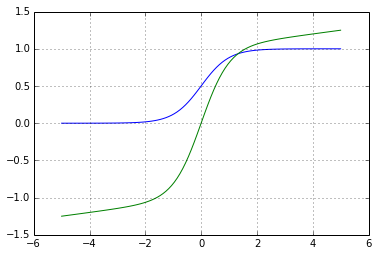

In [4]:
#nonlinearities
x_pts = np.linspace(-5,5,100)
plt.plot(x_pts, _tanh_zero_one(x_pts   ).eval())
plt.plot(x_pts, _tanh_leaky(x_pts).eval())
plt.grid()

In [25]:
#architecture

_nn = lasagne.layers.InputLayer(shape = input_shape,name='input_images',
                                input_var=_input_image_pair)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_inputs",p=0.2)

_nn = ChannelwiseDenseLayer(_nn,name_prefix = "retina.channel",
                     units_per_channel=512, nonlinearity = _tanh_leaky)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_concatenated_channels",p=0.25)


_nn = lasagne.layers.DenseLayer(_nn,name="dense.common.0",
                                num_units = 1024,
                                nonlinearity=lasagne.nonlinearities.sigmoid)

_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense0",p=0.25)

#_nn = lasagne.layers.DenseLayer(_nn,num_units = 1024,name="dense1",
#                             nonlinearity=lasagne.nonlinearities.sigmoid)

#_nn = lasagne.layers.DropoutLayer(_nn,name="drop_from_dense1",p=0.25)




_nn_out_map = ChanelwiseSoftmaxLayer( _nn, name_prefix='softmax_out',
                             neurons_per_channel=output_shape[-1],channels=['x','y','z'])



#_nn_out_map = lasagne.layers.DenseLayer(_nn,name="local_softmax_dense.output",
#                                num_units = np.prod(output_shape[1:]),
#                                nonlinearity=lasagne.nonlinearities.linear)

_nn_out_map = lasagne.layers.ReshapeLayer(_nn_out_map,shape = [-1]+output_shape[1:])


#_nn_out_map = LocalInhibitionLayer1D(_nn_out_map,name="local_softmax_inhibition.output",
#                                     n=7,k=0.01,d=1.,)



_nn_out_count = lasagne.layers.DenseLayer(_nn,name="dense_count",
                                          num_units=5,
                                          nonlinearity = lasagne.nonlinearities.softmax)


In [26]:
# network output function WITH random dropout
#raw shape: [ None,prod(output_shape) ]

_prediction_map = lasagne.layers.get_output(_nn_out_map,inputs=_input_image_pair)

_prediction_count = lasagne.layers.get_output(_nn_out_count,inputs=_input_image_pair)


## optimization objectives

In [27]:
# obtaining optimizable network parameters
_nn_weights = lasagne.layers.get_all_params([_nn_out_count,_nn_out_map],trainable=True) 
print _nn_weights, len(_nn_weights)

[retina.channel.0.dense.W, retina.channel.0.dense.b, retina.channel.1.dense.W, retina.channel.1.dense.b, retina.channel.2.dense.W, retina.channel.2.dense.b, retina.channel.3.dense.W, retina.channel.3.dense.b, dense.common.0.W, dense.common.0.b, dense_count.W, dense_count.b, softmax_outx.W, softmax_outx.b, softmax_outy.W, softmax_outy.b, softmax_outz.W, softmax_outz.b] 18


In [28]:
#constants for tweaking


_shared = lambda name,val: theano.shared(np.float32(val),name,strict = True)

_entropy_weight =_shared("entropy_weight",0)
_l2_weight = _shared("l2_weight",0.00001)


In [33]:
# prediction crossentropy
#_decay_mse = lasagne.objectives.squared_error(_prediction_map,_decay_map).mean()
#_crossentropy = lasagne.objectives.binary_crossentropy(_prediction_map,_decay_map).mean()
_crossentropy = lasagne.objectives.categorical_crossentropy(_prediction_map,_decay_map).mean()

_count_crossentropy = lasagne.objectives.categorical_crossentropy(_prediction_count,_decay_count).mean()


#[unused]
# cosine similarity with normalization applied to prediction only (since target Y is constant)
#from retina.compiled import normalize
#_prediction_normalized = normalize(_prediction).reshape([-1]+list(output_shape[1:]))
#_cosine_similarity = (_prediction_normalized*_decay_map).sum()


# all non-regularization terms
_unregularized_loss = _crossentropy + _count_crossentropy


In [34]:
# regularizers
"""
###entropy-based regularizer
#prediction entropy
_prediction_channels_entropy = lasagne.objectives.categorical_crossentropy(_prediction,_prediction)

#target entropy
_decay_map_soft = (_decay_map + 0.0001) #avoiding hard zeroes
_decay_map_soft = _decay_map_soft / T.sum(_decay_map_soft,axis=-1,keepdims=True) #normalizing

_decay_channels_entropy = lasagne.objectives.categorical_crossentropy(_decay_map_soft,_decay_map_soft)


_entropy_mse_over_channels = (_prediction_channels_entropy-_decay_channels_entropy)**2

_entropy_penalty = _entropy_mse_over_channels.mean()

_reg_entropy = _entropy_penalty * _entropy_weight

"""
# L2 (Tikhonov) regularizer
_weight_l2 = lasagne.regularization.regularize_network_params(_nn,
                            penalty = lasagne.regularization.l2)
_reg_l2 = _weight_l2 * _l2_weight






_loss = _unregularized_loss

if _l2_weight.get_value()!= 0:
    _loss += _reg_l2
if _entropy_weight.get_value() !=0:
    _loss += _reg_entropy
    

In [35]:
# optimization algorithm
_nn_update = lasagne.updates.nesterov_momentum(_loss,
                                               params = _nn_weights,
                                               learning_rate = .001
                                              )

In [36]:
# compiled optimization algorithm
train_fun = theano.function([_input_image_pair,_decay_map,_decay_count],
                            _loss,
                            updates=_nn_update,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )

In [37]:
# network output function WITHOUT dropout 
# dropout gets replaced with reweighting all outputs by (1 - P(drop) )
# thus, the output becomes DETERMINISTIC and uses whole network
_det_prediction_map = lasagne.layers.get_output(_nn_out_map,inputs=_input_image_pair,deterministic=True)
_det_prediction_count = lasagne.layers.get_output(_nn_out_count,inputs=_input_image_pair,deterministic=True)

# compiled deterministic output function (for evaluation and prediction)
predict = theano.function([_input_image_pair],[_det_prediction_map,_det_prediction_count])

In [38]:
_decay_count.dtype

'int32'

## evaluation functions

In [39]:
from sklearn.metrics import roc_auc_score,accuracy_score


metrics = [_loss,_unregularized_loss,
           _count_crossentropy,
           _reg_l2,
           _det_prediction_map,
           _det_prediction_count,]

score_fun = theano.function([_input_image_pair,_decay_map,_decay_count],
                             metrics,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )

from sklearn.metrics import roc_auc_score
def pseudo_auc_score_simple(y,y_pred,threshold = 0.8):
    """just a probability that a random target "1" will be rated by nn above a random background
    """
    
    true_selector = y>threshold
    
    return roc_auc_score(true_selector.ravel(),y_pred.ravel())

from retina.extremum import get_maxima

def pseudo_auc_score_extremal(y,y_pred):
    """just a probability that a random maxima will be rated by nn above a random non-maximum
    NOTE - in this case, the nn output is scaled to the norm of true output because
    predictions are normalized. 
    THAT DOES INTRODUCE A BIAS IN EVALUATION"""
    y_norms = np.linalg.norm(y,axis=-1,ord=1)[...,np.newaxis]
    y_pred *= y_norms

    true_maxima = get_maxima(y)#alarm - it's padded, last coord is true_coord-2
    true_maxima[-1] +=1 #account for padding

    true_selector = np.zeros_like(y,dtype=bool)
    true_selector[true_maxima]=1
    
    return roc_auc_score(true_selector.ravel(),y_pred.ravel())


from sklearn.metrics import accuracy_score
def evaluate(X,y_targ_map,y_targ_count):
    
    score,unreg_score,count_cce,reg_l2, y_pred_map, y_pred_count = score_fun(X,y_targ_map,y_targ_count)
    
    print 'full loss:',score
    print 'detection loss:',unreg_score
    print 'count crossentropy',count_cce
    print 'l2 penalty:',reg_l2
    print 'pseudo-auc',pseudo_auc_score_simple(y_targ_map,y_pred_map)
    print 'count-acc', accuracy_score(y_targ_count,y_pred_count.argmax(-1))
    
    return unreg_score
    

# fetch data
* load several retina images, concatenate them into pairs
 * a pair consists of two retina images of the SAME event
 * the difference is the position and orientation of the retina grid
* the retina images are 32x32 pixels each

(13603,)
(13603, 4, 32, 32) (13603, 3, 50) (13603,)


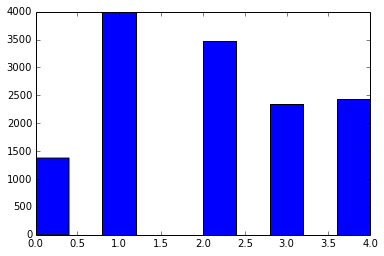

In [40]:
img_folder = "/mnt/KSfinder/finder/retinas_32"
import os
X = np.load(os.path.join(img_folder,"ksfinder_images.npy"))
y = np.load(os.path.join(img_folder,"ksfinder_targets.npy"))
y_count = np.load(os.path.join(img_folder,"ksfinder_target_counts.npy"))

print y_count.shape
y_count = y_count //4
y_count[y_count>4]=4 #>3 category
y_count = y_count.astype('int32')
plt.hist(y_count)

print X.shape,y.shape,y_count.shape

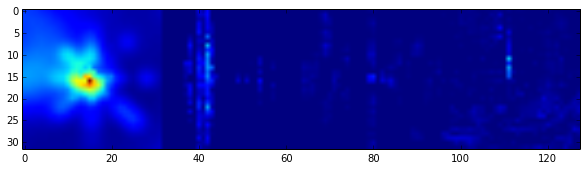

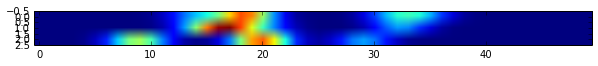

3


In [41]:
i = 0
plt.figure(figsize=[10,3])
plt.imshow(np.hstack(X[i]))
plt.show()
plt.figure(figsize=[10,3])
plt.imshow(np.vstack(y[i]))
plt.show()
print y_count[i]

In [42]:
#setup data format
X= X.reshape(-1,*input_shape[1:]).astype('float32')
y = y.reshape(-1,*output_shape[1:]).astype('float32')
print X.shape,y.shape

(13603, 4, 32, 32) (13603, 3, 1, 50)


In [43]:
from sklearn.cross_validation import train_test_split
Xtr,Xts,Ytr,Yts,Yctr,Ycts = train_test_split(X,y,y_count,test_size=0.2,random_state=42)

# train it
* by iteratively picking minibatches and training on them
* the method used for iterations is
 * Stochastic Gradient Descent (SGD) updates with Nesterov momentum
 * used it just because i heard it's good, no actual analysis done
* Uniform additive l2 regularization is applied to the network to prevent overfitting as well
 * regularization constant was briefly tweaked via crossvalidation for ROC AUC
 * more sophisticated regularizers were not analyzed

In [44]:
def iterate_minibatches(inputs, targets,target_counts,batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt],target_counts[excerpt]

In [45]:
import matplotlib

In [46]:
import random

def show_sample_predictions(X,y,yc,count=10,cmap=None,normalize = False):
    
    #select samples to show
    sample_indices = np.random.randint(0,len(y)-1,count)

    y_pred,y_pred_c = predict(X[sample_indices])
    
    y = y[sample_indices]
    
    if normalize:
        y/=np.linalg.norm(y,axis=-1,keepdims=True)
    
    
    for i in range(count):
        print 'count_distr:', y_pred_c[i],'actual:',yc[i]
        plt.figure(figsize=[20,2])
        plt.imshow(y[i].reshape(-1,50),interpolation='none',aspect=3,cmap=cmap)
        plt.title('sample %i reference'%sample_indices[i])
        plt.colorbar()
        plt.show()

        plt.figure(figsize=[20,2])
        plt.imshow(y_pred[i].reshape(-1,50),interpolation='none',aspect=3,cmap=cmap)
        plt.title('sample %i prediction'%sample_indices[i])
        plt.colorbar()
        plt.show()

In [47]:
#global epoch counter (useful if several train loops were started in succession)
epochCounter = 0
train_scores = {}
test_scores = {}

train loss during epoch 0 : 199.069351
train loss during epoch 0 : 187.554352
train loss during epoch 0 : 178.482117
train loss during epoch 0 : 175.885193
train loss during epoch 0 : 173.122559
train loss during epoch 0 : 170.500534
train loss during epoch 0 : 169.924759
train loss during epoch 0 : 168.082764
train loss during epoch 0 : 166.944260
train loss during epoch 0 : 166.722107
train loss during epoch 0 : 166.441772
train loss during epoch 0 : 166.706772
train loss during epoch 0 : 166.362091
train loss during epoch 0 : 165.468781
train loss during epoch 0 : 164.755890
train loss during epoch 0 : 164.379410
train loss during epoch 0 : 163.725769
train loss during epoch 0 : 163.191162
train loss during epoch 0 : 163.317703
train loss during epoch 0 : 163.195114
train loss during epoch 0 : 163.409958
train loss during epoch 0 : 163.401520
train loss during epoch 0 : 162.810501
train loss during epoch 0 : 162.747467
train loss during epoch 0 : 162.584915
train loss during epoch 0

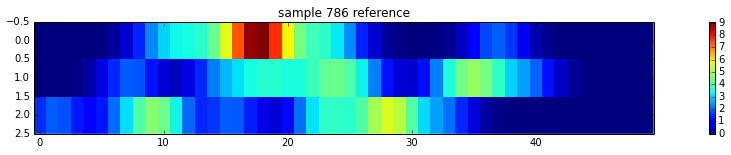

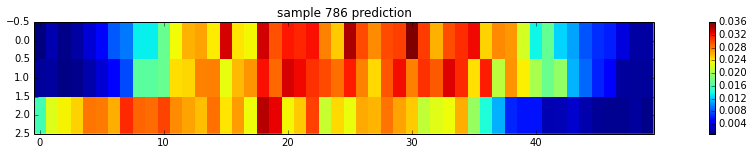

count_distr: [ 0.10235468  0.3176114   0.2334255   0.1578088   0.18879963] actual: 1


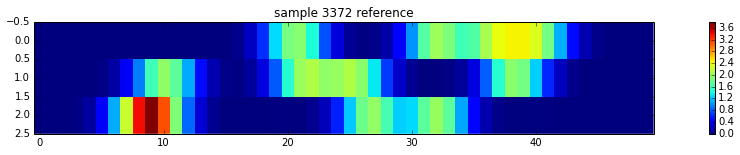

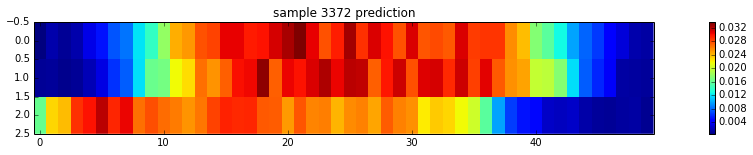

count_distr: [ 0.10996596  0.30190915  0.23330636  0.15638541  0.19843312] actual: 4


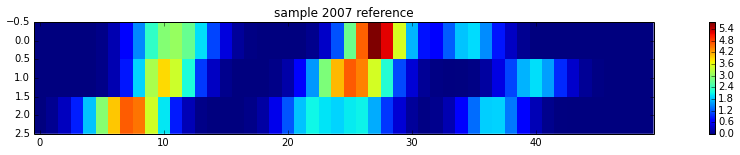

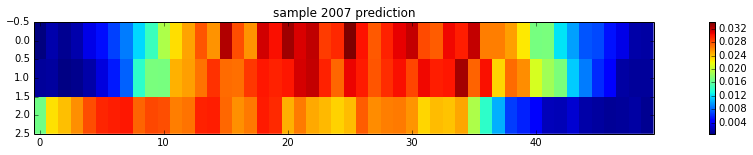

test score:
full loss: 157.235641479
detection loss: 157.185577393
count crossentropy 1.57930004597
l2 penalty: 0.0500608868897
pseudo-auc 0.713669236956
count-acc 0.28592429254

count_distr: [ 0.1109819   0.29127386  0.2339208   0.15664159  0.20718187] actual: 1


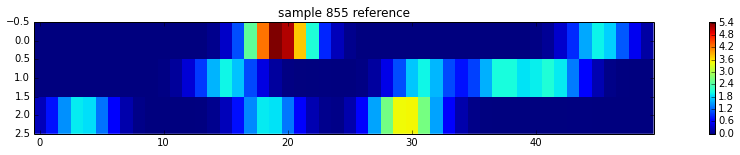

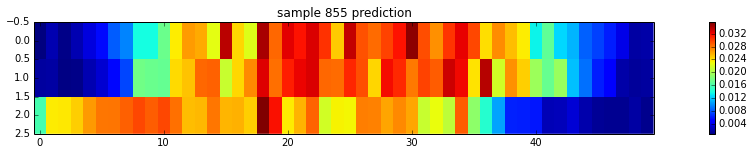

count_distr: [ 0.10420179  0.28323349  0.25093326  0.16361478  0.1980167 ] actual: 2


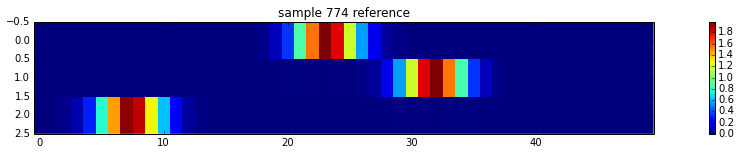

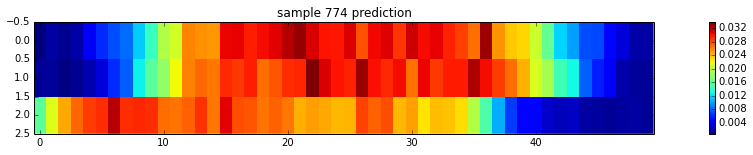

count_distr: [ 0.10713519  0.29818511  0.23286581  0.15491545  0.20689842] actual: 1


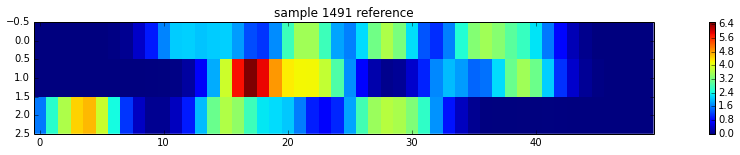

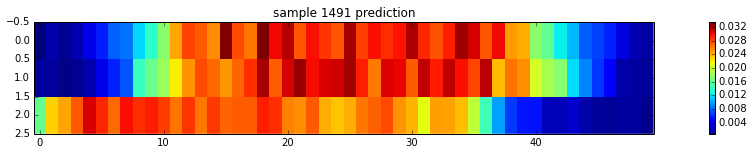

.........................
learning plots


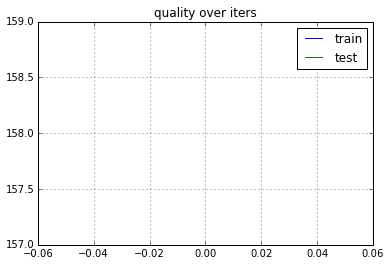

train loss during epoch 1 : 156.770584
train loss during epoch 1 : 159.234589
train loss during epoch 1 : 157.331421
train loss during epoch 1 : 158.939804
train loss during epoch 1 : 158.632492
train loss during epoch 1 : 157.244446
train loss during epoch 1 : 158.231567
train loss during epoch 1 : 160.378815
train loss during epoch 1 : 159.394424
train loss during epoch 1 : 159.016998
train loss during epoch 1 : 159.164368
train loss during epoch 1 : 159.078537
train loss during epoch 1 : 159.528320
train loss during epoch 1 : 158.915558
train loss during epoch 1 : 158.158615
train loss during epoch 1 : 158.277466
train loss during epoch 1 : 158.282990
train loss during epoch 1 : 157.631470
train loss during epoch 1 : 158.052856
train loss during epoch 1 : 158.015915
train loss during epoch 1 : 157.836594
train loss during epoch 1 : 158.096405
train loss during epoch 1 : 157.959778
train loss during epoch 1 : 158.147598
train loss during epoch 1 : 158.251480
train loss during epoch 1

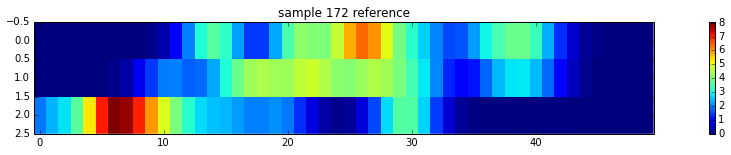

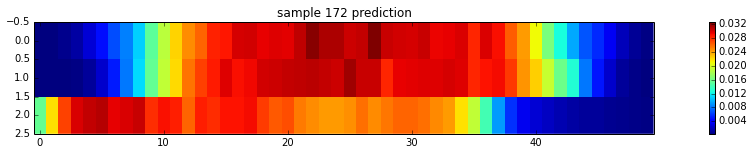

count_distr: [ 0.10321262  0.2882444   0.24655201  0.17831908  0.18367191] actual: 1


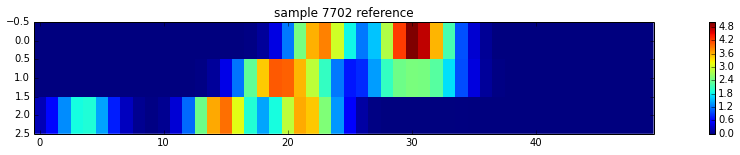

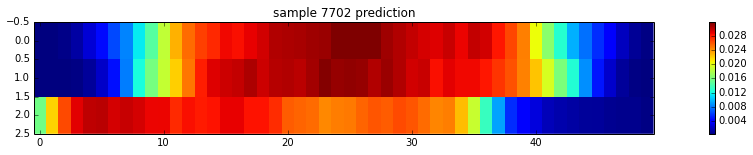

count_distr: [ 0.10527659  0.28766471  0.24578249  0.1772292   0.184047  ] actual: 4


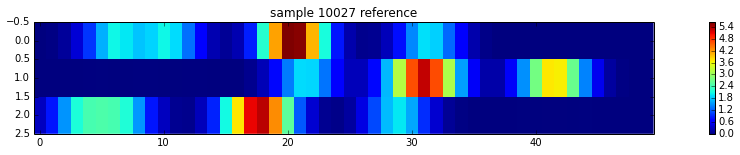

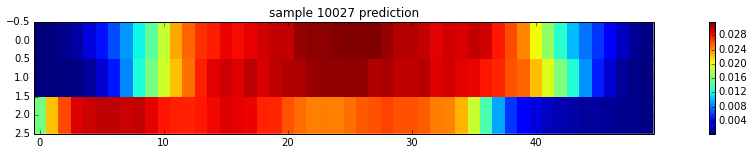

test score:
full loss: 155.609848022
detection loss: 155.559799194
count crossentropy 1.5570422411
l2 penalty: 0.0500476434827
pseudo-auc 0.716244954891
count-acc 0.285189268651

count_distr: [ 0.10194015  0.2829712   0.24672745  0.17979588  0.18856531] actual: 1


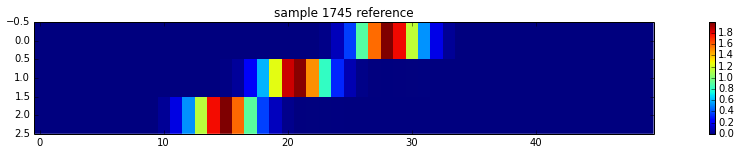

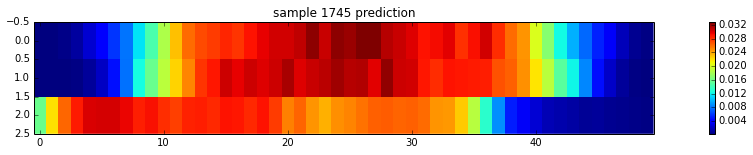

count_distr: [ 0.10568061  0.29159185  0.2519944   0.17427255  0.17646058] actual: 2


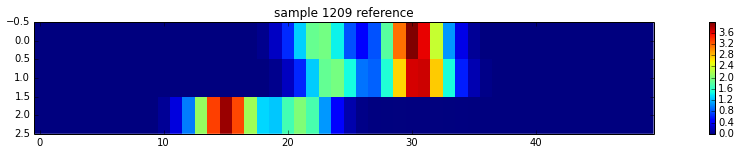

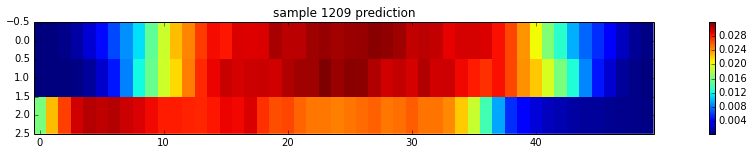

count_distr: [ 0.10507327  0.28716087  0.24512909  0.17597379  0.18666297] actual: 1


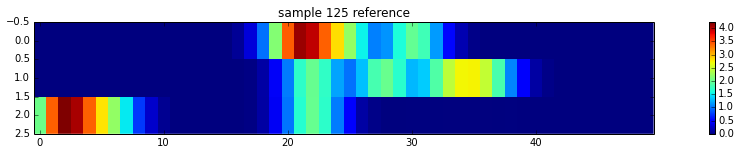

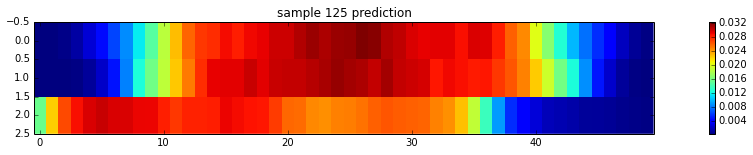

.........................
learning plots


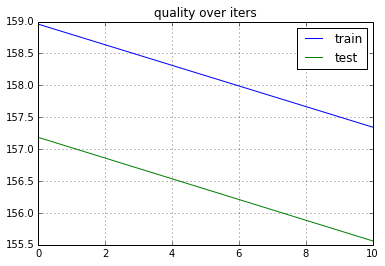

train loss during epoch 11 : 165.866684
train loss during epoch 11 : 166.958069
train loss during epoch 11 : 165.222610
train loss during epoch 11 : 162.231689
train loss during epoch 11 : 159.529617
train loss during epoch 11 : 160.495102
train loss during epoch 11 : 160.306244
train loss during epoch 11 : 158.714996
train loss during epoch 11 : 159.076126
train loss during epoch 11 : 159.163132
train loss during epoch 11 : 158.768707
train loss during epoch 11 : 158.310028
train loss during epoch 11 : 158.636948
train loss during epoch 11 : 158.819595
train loss during epoch 11 : 158.794144
train loss during epoch 11 : 158.585236
train loss during epoch 11 : 158.443619
train loss during epoch 11 : 157.835724
train loss during epoch 11 : 157.901978
train loss during epoch 11 : 157.688217
train loss during epoch 11 : 158.073288
train loss during epoch 11 : 158.087784
train loss during epoch 11 : 157.821442
train loss during epoch 11 : 157.893417
train loss during epoch 11 : 157.912460


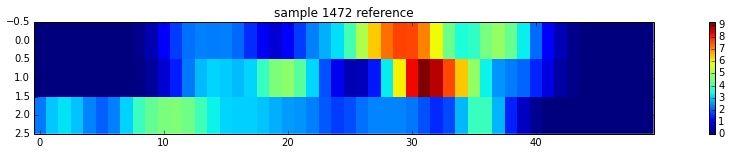

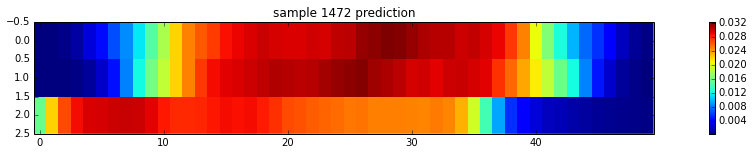

count_distr: [ 0.09874647  0.28808001  0.25157031  0.17372826  0.18787497] actual: 1


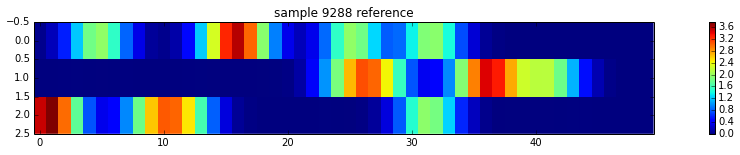

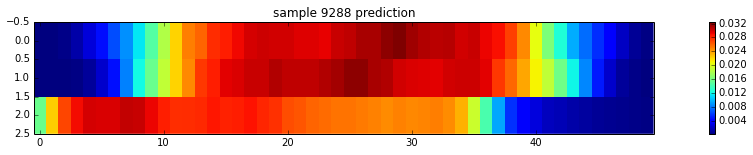

count_distr: [ 0.10189923  0.29449695  0.24919979  0.1726511   0.18175292] actual: 4


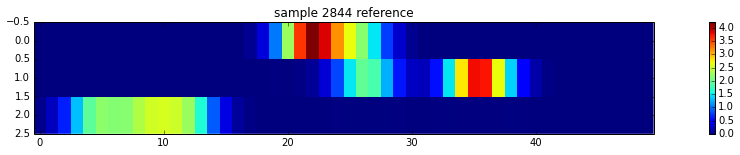

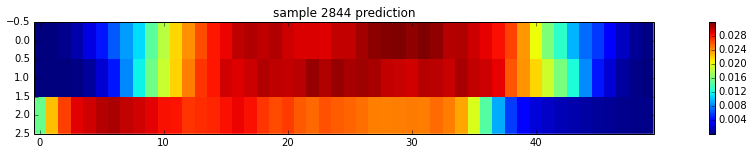

test score:
full loss: 155.458786011
detection loss: 155.408752441
count crossentropy 1.55663466454
l2 penalty: 0.0500403642654
pseudo-auc 0.715964161417
count-acc 0.285189268651

count_distr: [ 0.10087389  0.28984606  0.25129849  0.17334111  0.18464045] actual: 1


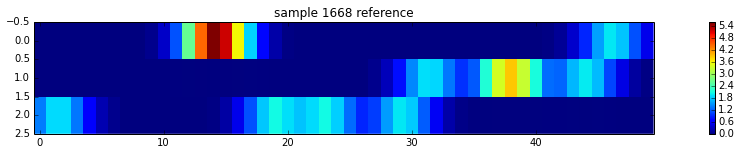

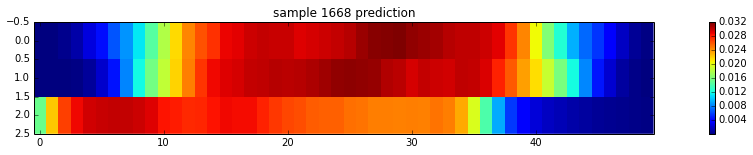

count_distr: [ 0.09692141  0.29222959  0.25154048  0.17290749  0.18640104] actual: 2


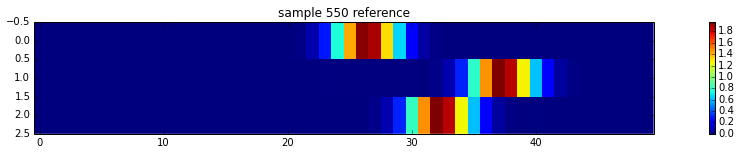

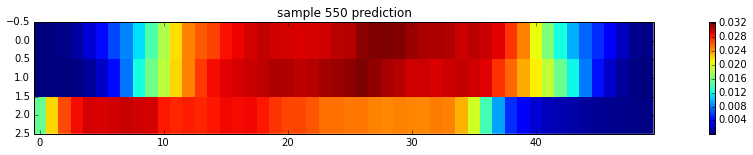

count_distr: [ 0.10019383  0.29412648  0.2477961   0.17370234  0.18418124] actual: 1


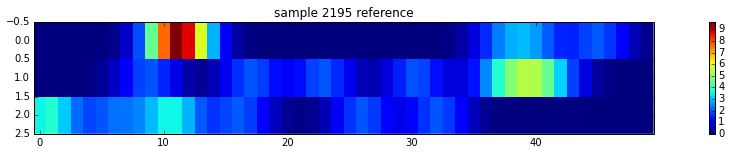

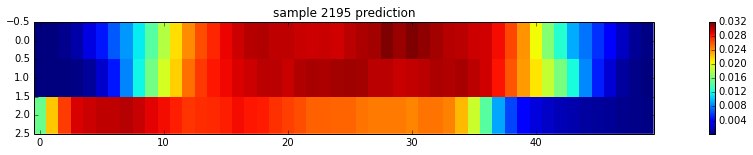

.........................
learning plots


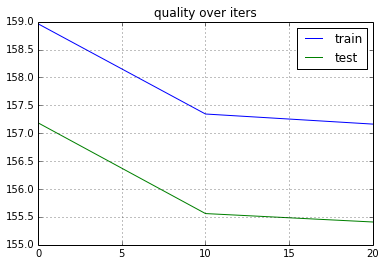

train loss during epoch 21 : 158.484268
train loss during epoch 21 : 155.475143
train loss during epoch 21 : 157.880951
train loss during epoch 21 : 157.975266
train loss during epoch 21 : 156.582291
train loss during epoch 21 : 154.741302
train loss during epoch 21 : 154.271698
train loss during epoch 21 : 154.501404
train loss during epoch 21 : 155.887100
train loss during epoch 21 : 155.899643
train loss during epoch 21 : 155.512619
train loss during epoch 21 : 155.749832
train loss during epoch 21 : 155.682938
train loss during epoch 21 : 155.867157
train loss during epoch 21 : 156.358673
train loss during epoch 21 : 155.934662
train loss during epoch 21 : 155.790604
train loss during epoch 21 : 156.111053
train loss during epoch 21 : 156.536621
train loss during epoch 21 : 156.563370
train loss during epoch 21 : 156.713745
train loss during epoch 21 : 156.547577
train loss during epoch 21 : 156.632660
train loss during epoch 21 : 156.430359
train loss during epoch 21 : 156.302704


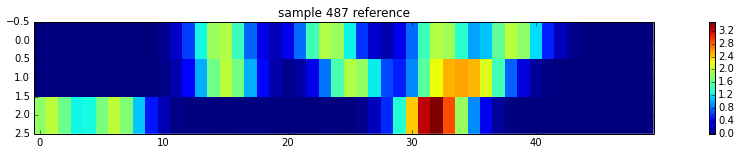

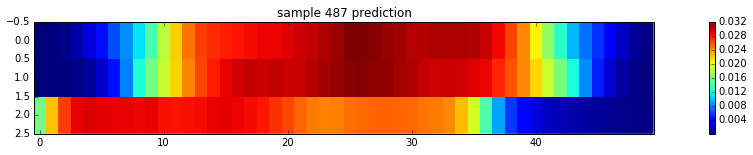

count_distr: [ 0.09942126  0.29135668  0.25354388  0.17224273  0.18343545] actual: 1


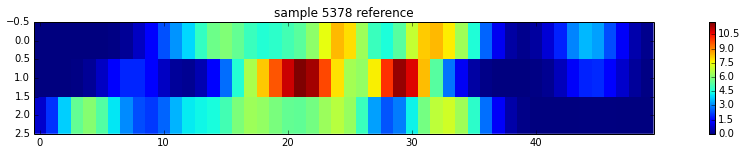

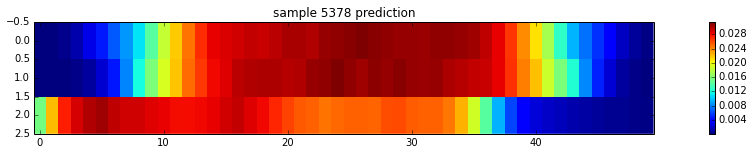

count_distr: [ 0.10025576  0.2877275   0.25546804  0.17475936  0.18178934] actual: 4


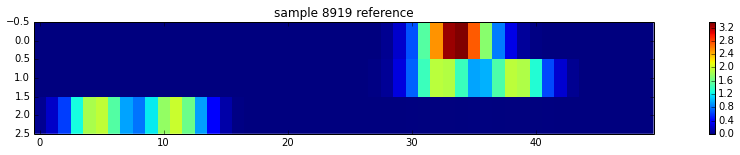

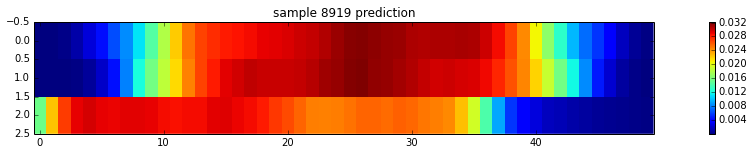

test score:
full loss: 155.39932251
detection loss: 155.34928894
count crossentropy 1.55090010166
l2 penalty: 0.0500334464014
pseudo-auc 0.716274603306
count-acc 0.285189268651

count_distr: [ 0.1002332   0.29209876  0.25579381  0.16916217  0.18271203] actual: 1


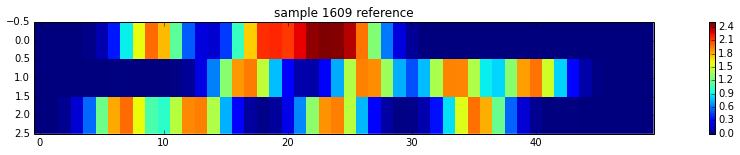

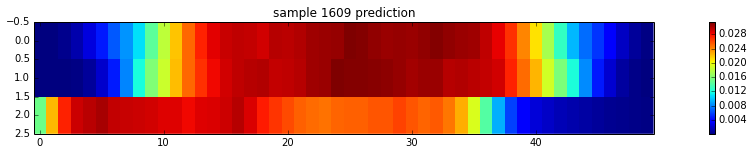

count_distr: [ 0.1019128   0.29092154  0.25540635  0.17194402  0.17981528] actual: 2


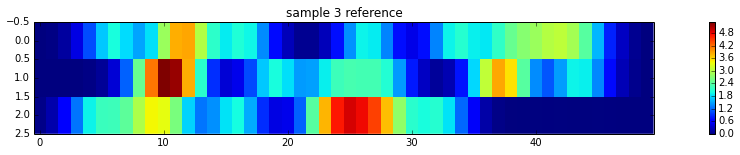

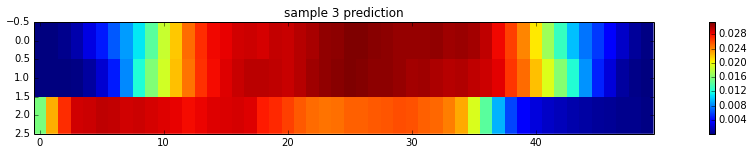

count_distr: [ 0.10098454  0.28573808  0.25354201  0.1736798   0.18605557] actual: 1


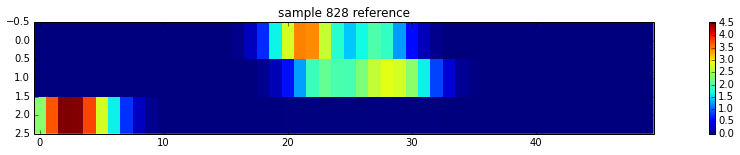

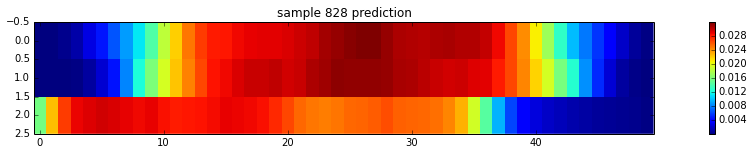

.........................
learning plots


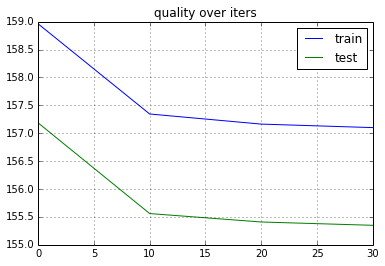

train loss during epoch 31 : 156.073273
train loss during epoch 31 : 159.678024
train loss during epoch 31 : 156.557693
train loss during epoch 31 : 155.436249
train loss during epoch 31 : 153.279251
train loss during epoch 31 : 154.707733
train loss during epoch 31 : 154.778397
train loss during epoch 31 : 155.214371
train loss during epoch 31 : 155.895081
train loss during epoch 31 : 156.128891
train loss during epoch 31 : 156.335648
train loss during epoch 31 : 156.314438
train loss during epoch 31 : 156.360901
train loss during epoch 31 : 156.307144
train loss during epoch 31 : 156.617218
train loss during epoch 31 : 156.824371
train loss during epoch 31 : 156.377380
train loss during epoch 31 : 156.279938
train loss during epoch 31 : 156.327820
train loss during epoch 31 : 156.286270
train loss during epoch 31 : 156.089798
train loss during epoch 31 : 156.152145
train loss during epoch 31 : 156.472610
train loss during epoch 31 : 156.958481
train loss during epoch 31 : 156.792328


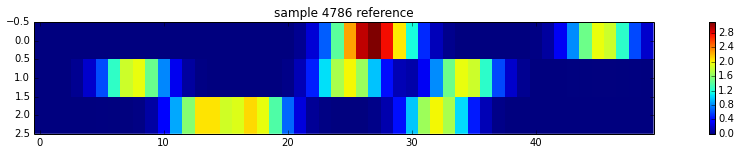

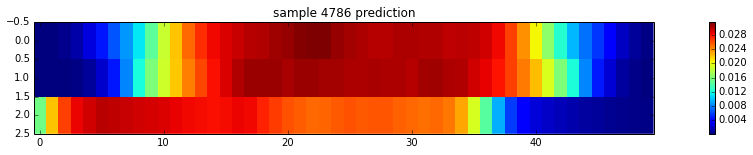

count_distr: [ 0.10130608  0.29088345  0.25089645  0.16887991  0.18803409] actual: 1


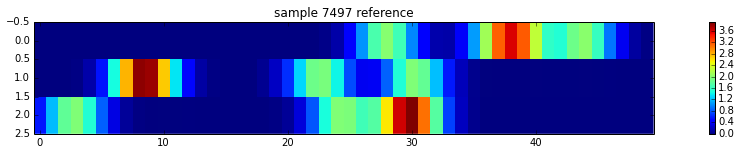

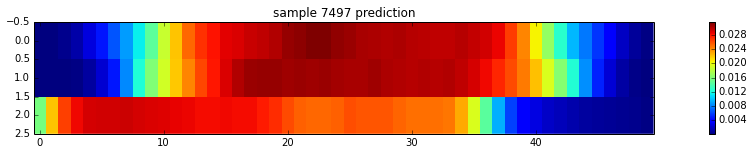

count_distr: [ 0.09979216  0.29057136  0.25312382  0.16951306  0.18699959] actual: 4


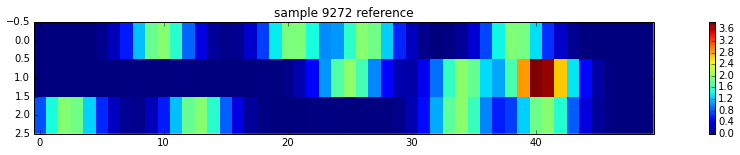

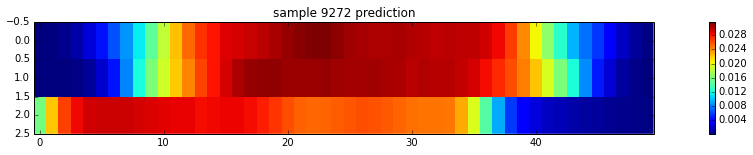

test score:
full loss: 155.379623413
detection loss: 155.329589844
count crossentropy 1.55415010452
l2 penalty: 0.0500264503062
pseudo-auc 0.716141051699
count-acc 0.285189268651

count_distr: [ 0.09932575  0.29166919  0.2535331   0.16873486  0.18673711] actual: 1


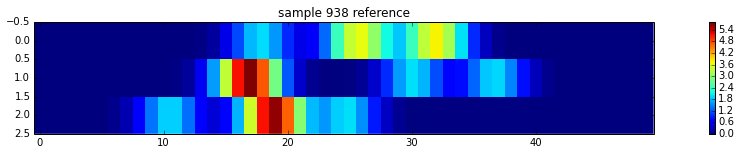

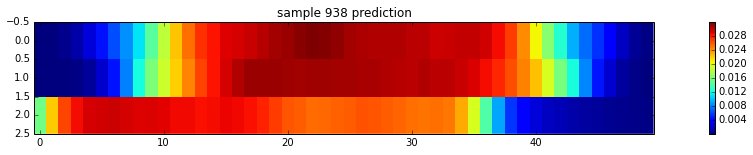

count_distr: [ 0.09902032  0.29344165  0.253755    0.16839895  0.18538408] actual: 2


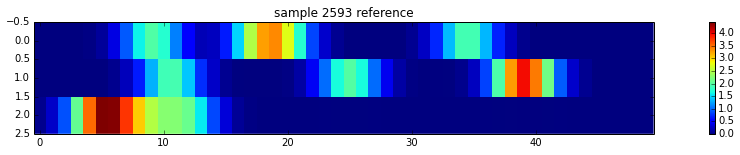

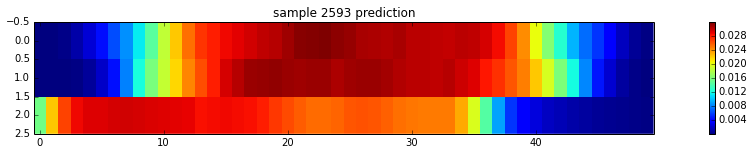

count_distr: [ 0.09877344  0.29138273  0.25328967  0.16969706  0.1868571 ] actual: 1


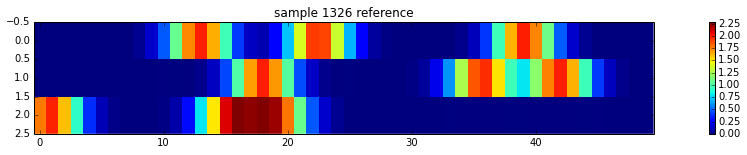

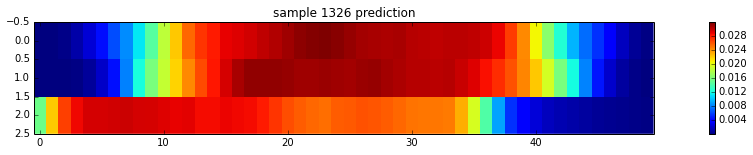

.........................
learning plots


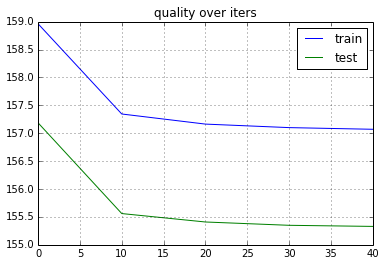

train loss during epoch 41 : 151.750656
train loss during epoch 41 : 156.598801
train loss during epoch 41 : 158.270767
train loss during epoch 41 : 158.834869
train loss during epoch 41 : 159.919510
train loss during epoch 41 : 160.717712
train loss during epoch 41 : 161.683258
train loss during epoch 41 : 161.414291
train loss during epoch 41 : 160.508881
train loss during epoch 41 : 159.642853
train loss during epoch 41 : 159.752777
train loss during epoch 41 : 159.411179
train loss during epoch 41 : 159.837997
train loss during epoch 41 : 159.120956
train loss during epoch 41 : 158.369598
train loss during epoch 41 : 158.238800
train loss during epoch 41 : 158.153824
train loss during epoch 41 : 157.898178
train loss during epoch 41 : 157.251297
train loss during epoch 41 : 157.614655
train loss during epoch 41 : 157.205414
train loss during epoch 41 : 157.639755
train loss during epoch 41 : 157.106644
train loss during epoch 41 : 157.106766
train loss during epoch 41 : 157.278305


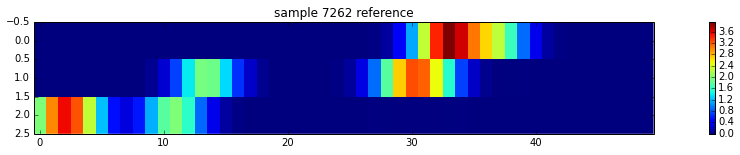

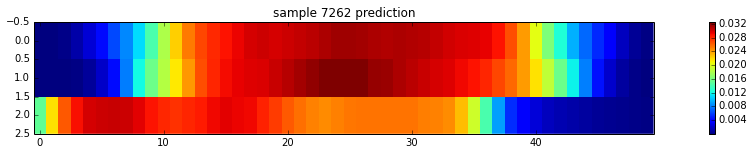

count_distr: [ 0.10255912  0.29798773  0.24442218  0.16547567  0.18955529] actual: 1


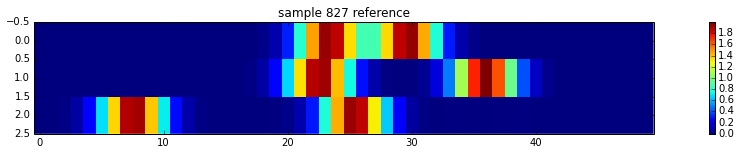

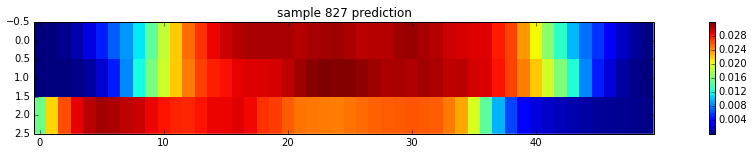

count_distr: [ 0.10077053  0.29756981  0.24303189  0.16980232  0.18882546] actual: 4


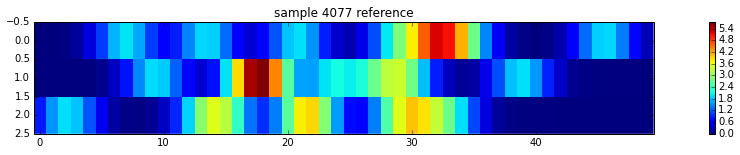

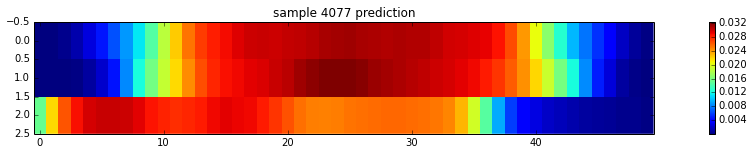

test score:
full loss: 155.346099854
detection loss: 155.296081543
count crossentropy 1.55433166027
l2 penalty: 0.0500191748142
pseudo-auc 0.716642730443
count-acc 0.285189268651

count_distr: [ 0.09857089  0.29668942  0.24556136  0.17090942  0.18826893] actual: 1


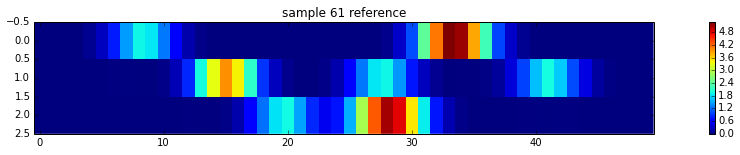

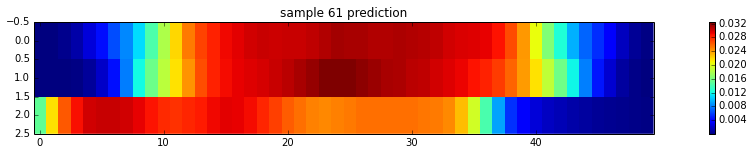

count_distr: [ 0.09985838  0.2977218   0.2436471   0.16926982  0.18950292] actual: 2


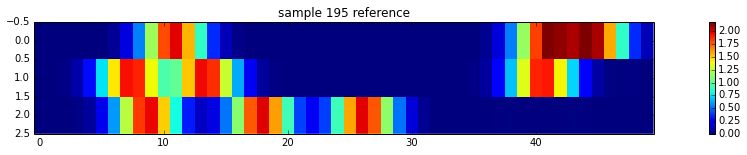

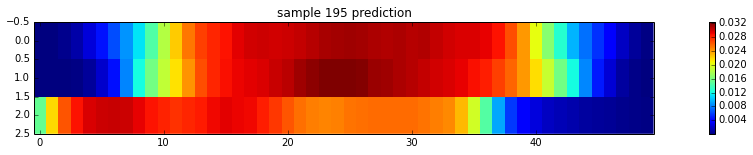

count_distr: [ 0.09967116  0.3017354   0.24462366  0.16743201  0.18653776] actual: 1


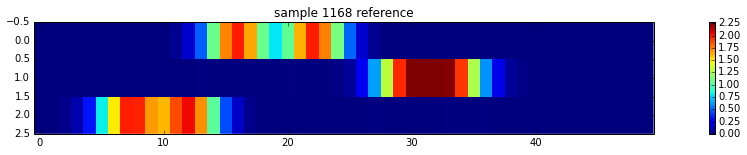

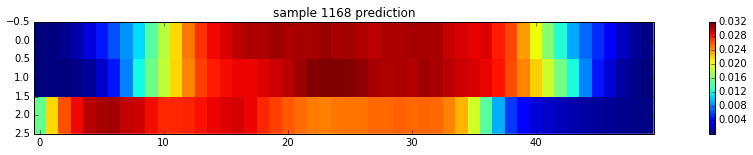

.........................
learning plots


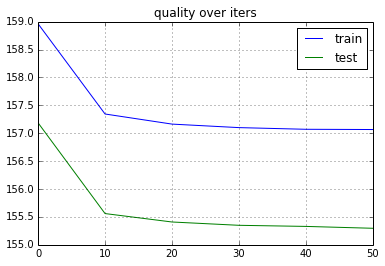

train loss during epoch 51 : 159.842468
train loss during epoch 51 : 156.698944
train loss during epoch 51 : 157.417130
train loss during epoch 51 : 158.216568
train loss during epoch 51 : 158.995514
train loss during epoch 51 : 158.646820
train loss during epoch 51 : 158.033524
train loss during epoch 51 : 158.375183
train loss during epoch 51 : 159.879333
train loss during epoch 51 : 159.307495
train loss during epoch 51 : 159.743866
train loss during epoch 51 : 159.734818
train loss during epoch 51 : 160.134460
train loss during epoch 51 : 160.015518
train loss during epoch 51 : 159.357773
train loss during epoch 51 : 159.177917
train loss during epoch 51 : 158.969589
train loss during epoch 51 : 158.459091
train loss during epoch 51 : 158.394592
train loss during epoch 51 : 158.449341
train loss during epoch 51 : 158.062088
train loss during epoch 51 : 157.984802
train loss during epoch 51 : 158.009171
train loss during epoch 51 : 157.764816
train loss during epoch 51 : 157.534454


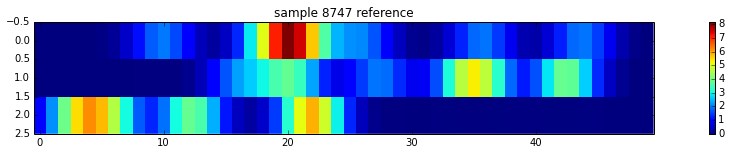

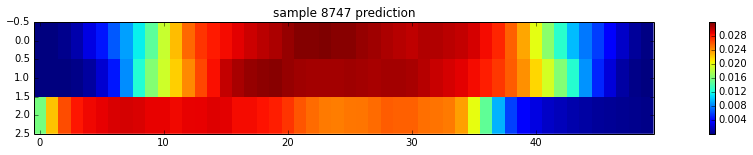

count_distr: [ 0.09981295  0.29097253  0.24842606  0.17383954  0.18694891] actual: 1


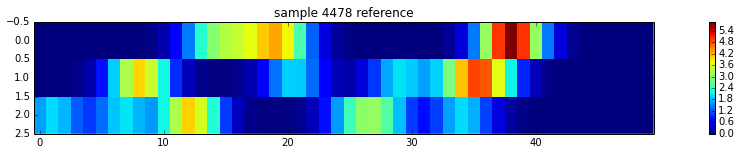

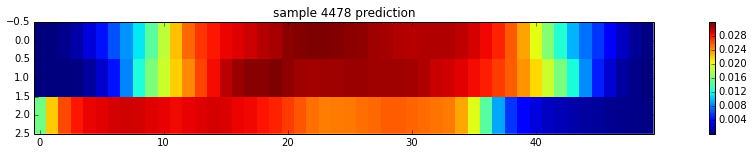

count_distr: [ 0.1004204   0.29272842  0.24890274  0.17273723  0.18521121] actual: 4


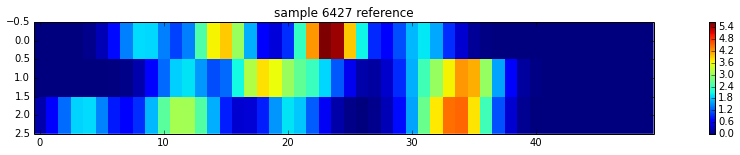

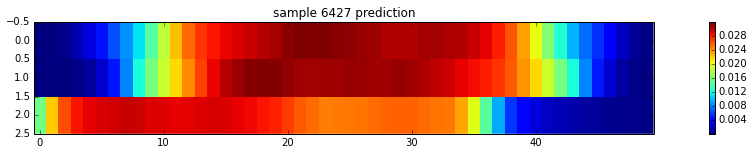

test score:
full loss: 155.355636597
detection loss: 155.305618286
count crossentropy 1.55298483372
l2 penalty: 0.0500118099153
pseudo-auc 0.716051209735
count-acc 0.285189268651

count_distr: [ 0.10054571  0.28999189  0.24856497  0.1744633   0.18643412] actual: 1


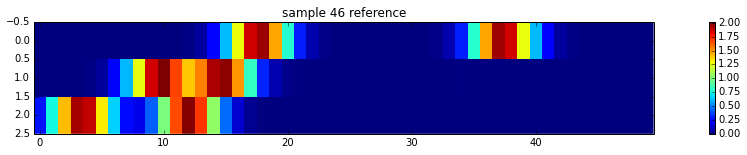

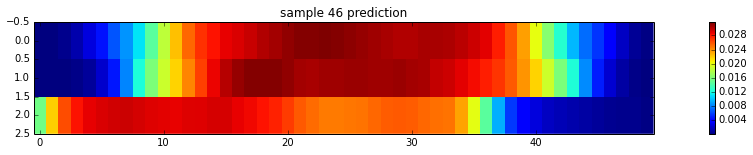

count_distr: [ 0.10036121  0.29076546  0.24870163  0.17333889  0.18683282] actual: 2


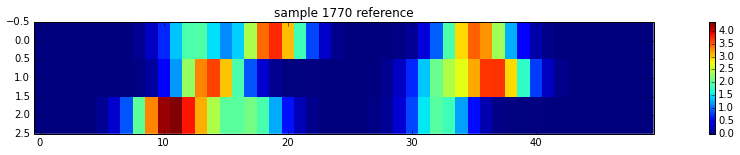

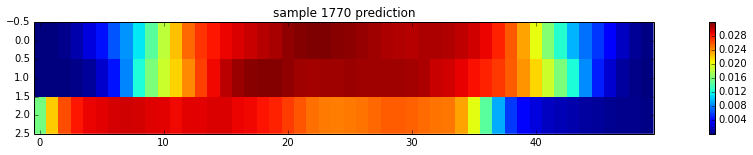

count_distr: [ 0.10031199  0.29240313  0.24824341  0.17213596  0.18690549] actual: 1


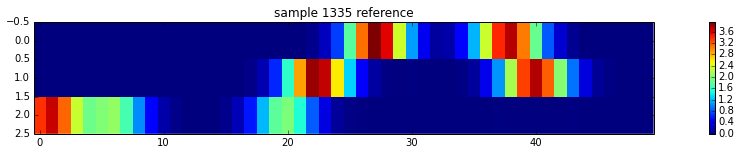

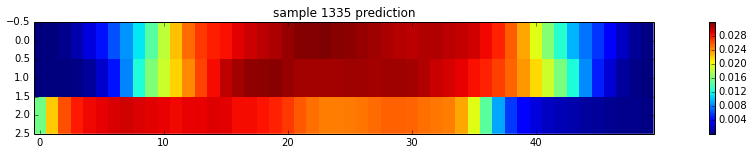

.........................
learning plots


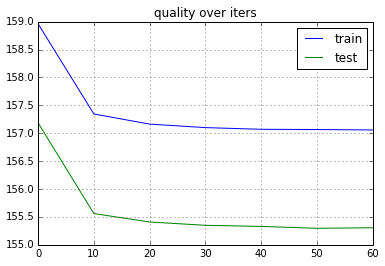

train loss during epoch 61 : 165.103851
train loss during epoch 61 : 162.261536
train loss during epoch 61 : 158.836014
train loss during epoch 61 : 159.363220
train loss during epoch 61 : 160.257965
train loss during epoch 61 : 160.181747
train loss during epoch 61 : 160.206665
train loss during epoch 61 : 159.137054
train loss during epoch 61 : 158.516998
train loss during epoch 61 : 157.795197
train loss during epoch 61 : 157.997238
train loss during epoch 61 : 157.877075
train loss during epoch 61 : 157.965988
train loss during epoch 61 : 157.540787
train loss during epoch 61 : 157.607758
train loss during epoch 61 : 158.357834
train loss during epoch 61 : 158.304886
train loss during epoch 61 : 157.895035
train loss during epoch 61 : 158.029587
train loss during epoch 61 : 157.962936
train loss during epoch 61 : 157.785431
train loss during epoch 61 : 157.770447
train loss during epoch 61 : 157.913422
train loss during epoch 61 : 157.719162
train loss during epoch 61 : 157.125992


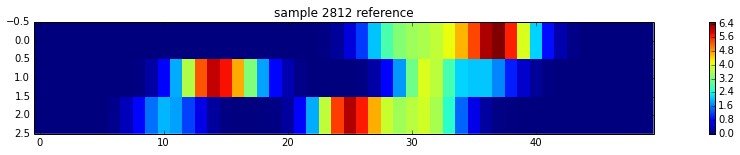

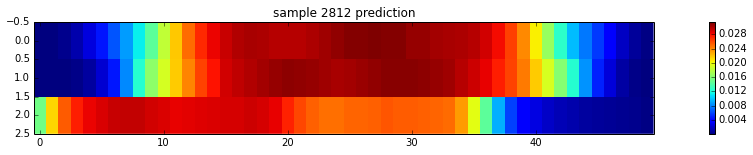

count_distr: [ 0.09791408  0.29693738  0.25593668  0.17129812  0.17791371] actual: 1


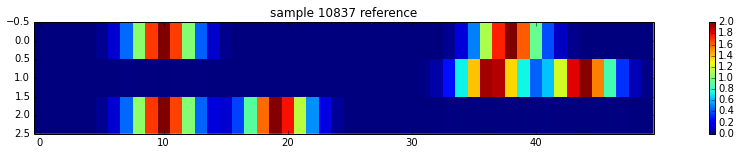

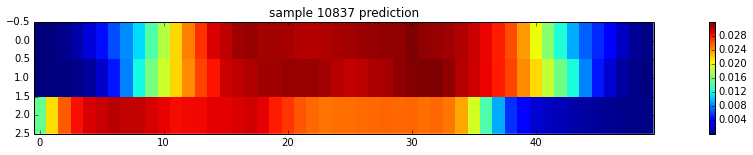

count_distr: [ 0.10241208  0.29030153  0.2560311   0.1717573   0.179498  ] actual: 4


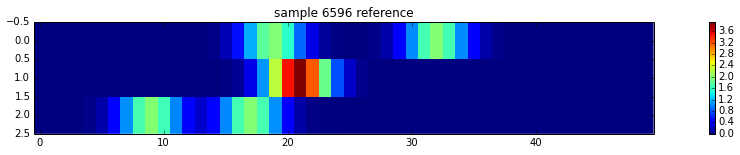

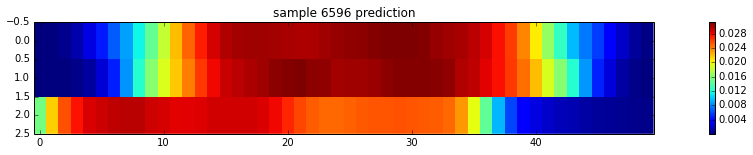

test score:
full loss: 155.348114014
detection loss: 155.298110962
count crossentropy 1.55255317688
l2 penalty: 0.0500044375658
pseudo-auc 0.716407643039
count-acc 0.285189268651

count_distr: [ 0.10302209  0.29739827  0.25429678  0.16567817  0.17960468] actual: 1


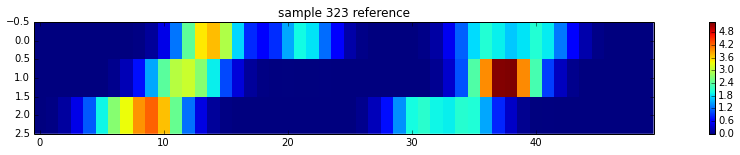

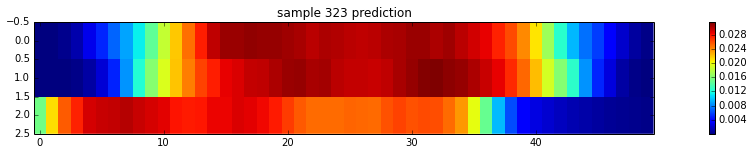

count_distr: [ 0.10206302  0.28951269  0.25604054  0.17188066  0.18050307] actual: 2


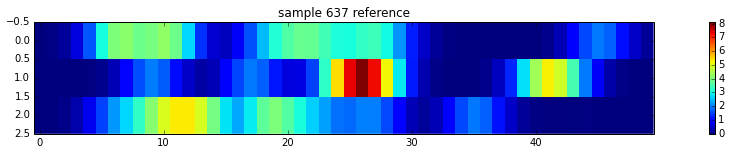

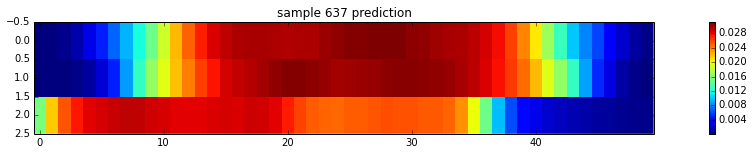

count_distr: [ 0.10064066  0.29064444  0.25592002  0.17171916  0.18107571] actual: 1


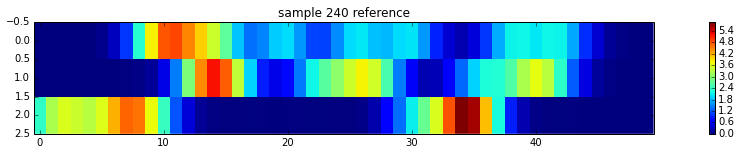

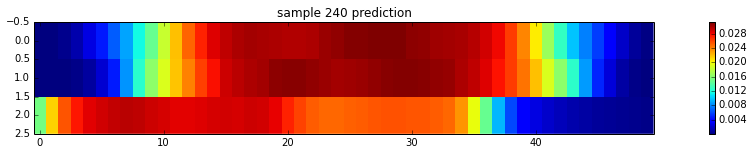

.........................
learning plots


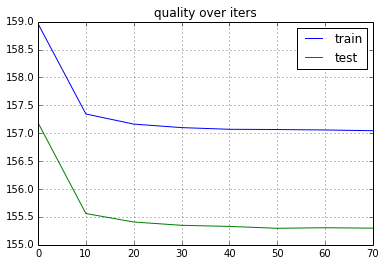

train loss during epoch 71 : 148.211487
train loss during epoch 71 : 151.730194
train loss during epoch 71 : 156.499573
train loss during epoch 71 : 155.719284
train loss during epoch 71 : 153.894165
train loss during epoch 71 : 153.651031
train loss during epoch 71 : 153.769943
train loss during epoch 71 : 153.602234
train loss during epoch 71 : 154.264679
train loss during epoch 71 : 154.016144
train loss during epoch 71 : 154.231308
train loss during epoch 71 : 154.220596
train loss during epoch 71 : 153.903778
train loss during epoch 71 : 154.339706
train loss during epoch 71 : 154.628067
train loss during epoch 71 : 154.136749
train loss during epoch 71 : 153.868332
train loss during epoch 71 : 154.627747
train loss during epoch 71 : 154.910751
train loss during epoch 71 : 155.552429
train loss during epoch 71 : 156.146011
train loss during epoch 71 : 156.293274
train loss during epoch 71 : 155.947174
train loss during epoch 71 : 155.743790
train loss during epoch 71 : 155.471252


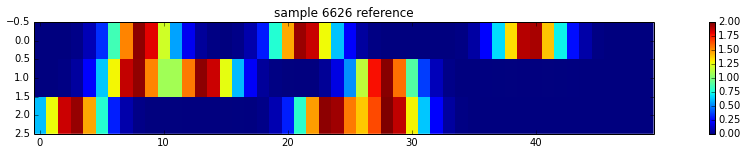

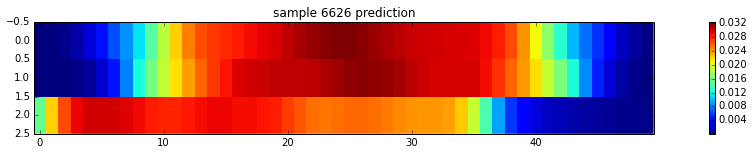

count_distr: [ 0.09906276  0.29162034  0.2483269   0.17507248  0.18591751] actual: 1


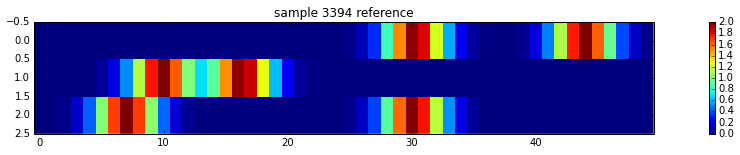

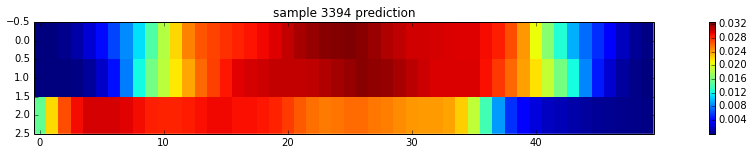

count_distr: [ 0.10000233  0.29114631  0.24785604  0.17580354  0.18519178] actual: 4


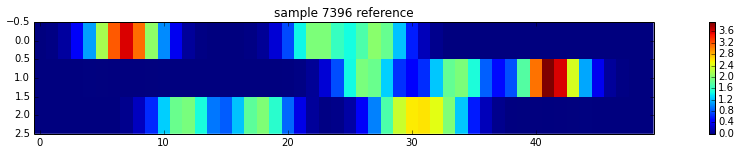

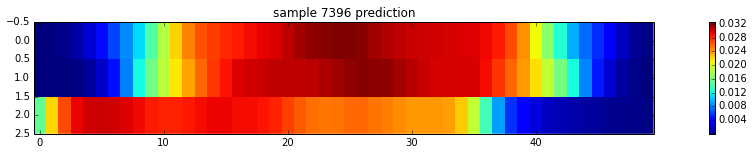

test score:
full loss: 155.363113403
detection loss: 155.313110352
count crossentropy 1.55216753483
l2 penalty: 0.0499969534576
pseudo-auc 0.716451923629
count-acc 0.285189268651

count_distr: [ 0.10017814  0.29192674  0.24702321  0.17506026  0.18581165] actual: 1


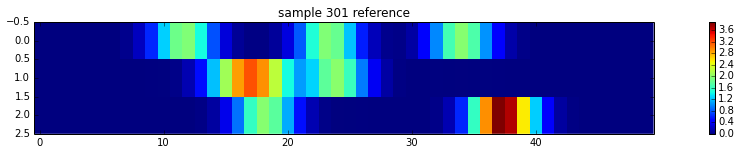

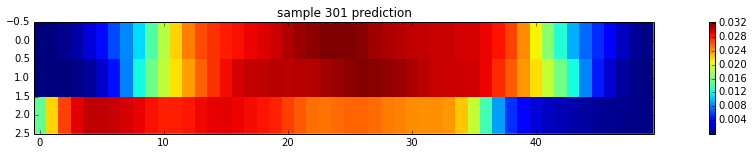

count_distr: [ 0.10015056  0.29134849  0.24777341  0.17528476  0.18544278] actual: 2


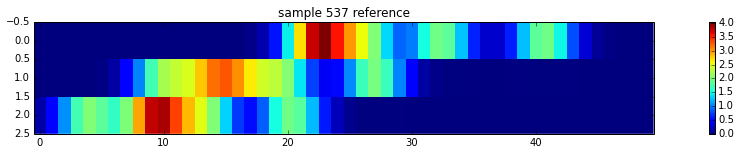

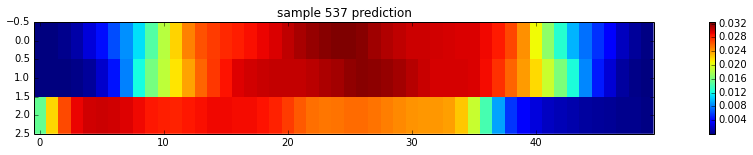

count_distr: [ 0.10025258  0.28935713  0.24856241  0.17622426  0.18560362] actual: 1


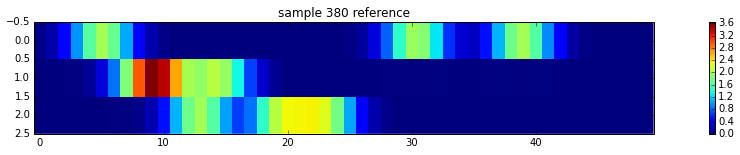

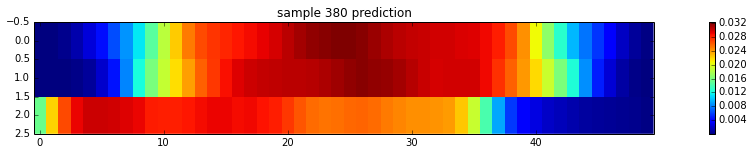

.........................
learning plots


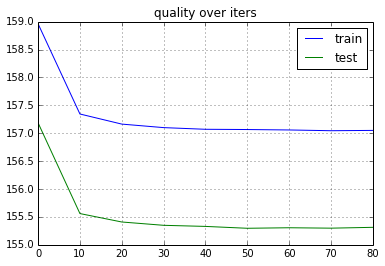

train loss during epoch 81 : 158.037659
train loss during epoch 81 : 157.421432
train loss during epoch 81 : 157.139481
train loss during epoch 81 : 154.240997
train loss during epoch 81 : 155.457840
train loss during epoch 81 : 156.100403
train loss during epoch 81 : 155.579559
train loss during epoch 81 : 154.655701
train loss during epoch 81 : 154.913834
train loss during epoch 81 : 155.087692
train loss during epoch 81 : 156.325256
train loss during epoch 81 : 156.522125
train loss during epoch 81 : 157.882889
train loss during epoch 81 : 157.548187
train loss during epoch 81 : 157.421387
train loss during epoch 81 : 157.167908
train loss during epoch 81 : 156.993256
train loss during epoch 81 : 156.691833
train loss during epoch 81 : 157.125183
train loss during epoch 81 : 157.168365
train loss during epoch 81 : 157.240021
train loss during epoch 81 : 157.083725
train loss during epoch 81 : 157.280563
train loss during epoch 81 : 157.088806
train loss during epoch 81 : 156.876724


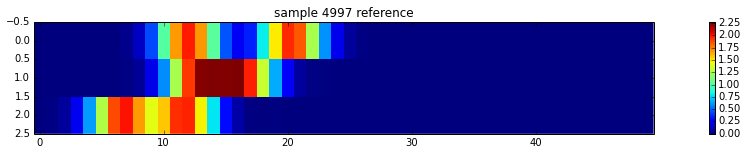

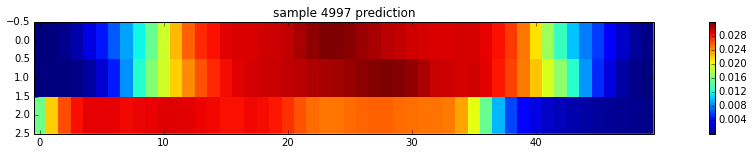

count_distr: [ 0.1022305   0.28790009  0.25798759  0.17077634  0.18110548] actual: 1


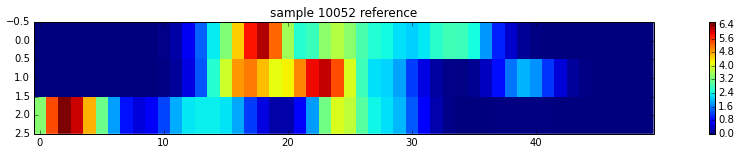

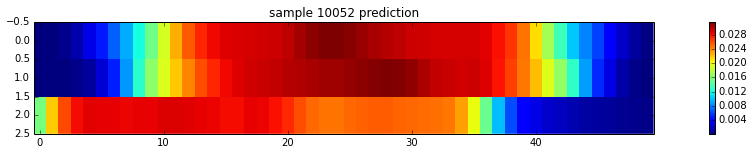

count_distr: [ 0.10026774  0.29096395  0.25784713  0.17021829  0.18070288] actual: 4


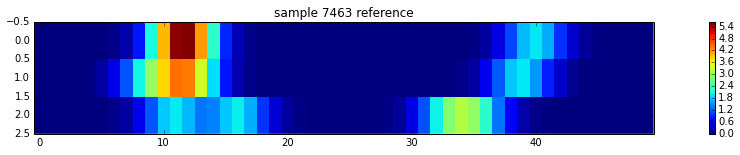

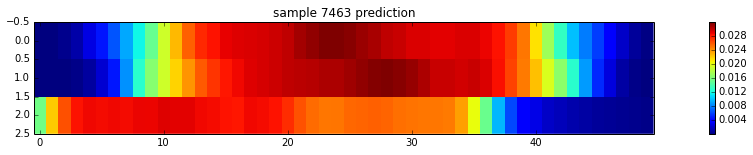

test score:
full loss: 155.354522705
detection loss: 155.304534912
count crossentropy 1.55331683159
l2 penalty: 0.0499893836677
pseudo-auc 0.716900435501
count-acc 0.285189268651

count_distr: [ 0.10130505  0.28958935  0.25889906  0.17009884  0.18010768] actual: 1


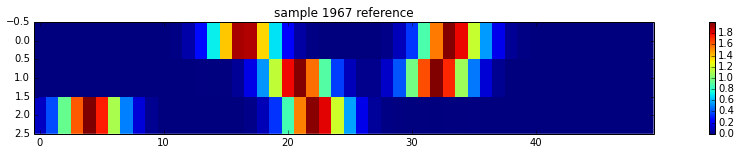

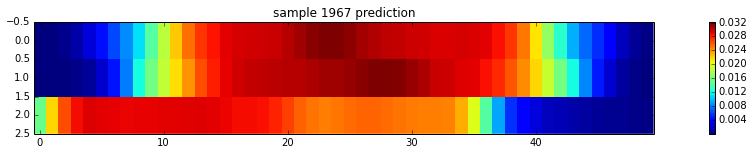

count_distr: [ 0.1001488   0.28948873  0.25734711  0.17069969  0.18231566] actual: 2


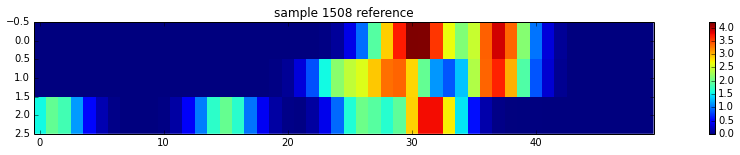

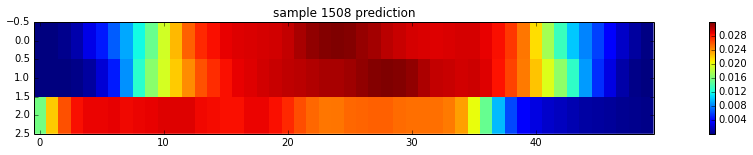

count_distr: [ 0.0991895   0.29068413  0.2591089   0.17013413  0.18088336] actual: 1


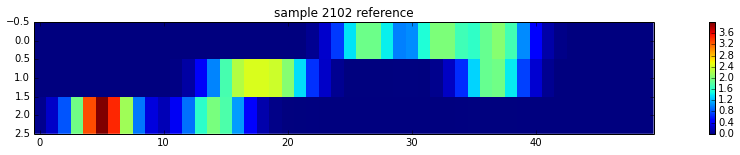

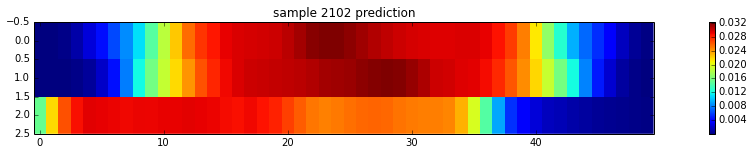

.........................
learning plots


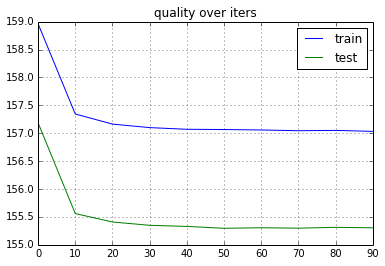

train loss during epoch 91 : 158.598022
train loss during epoch 91 : 157.864166
train loss during epoch 91 : 155.410858
train loss during epoch 91 : 154.564621
train loss during epoch 91 : 155.377319
train loss during epoch 91 : 155.683945
train loss during epoch 91 : 154.213028
train loss during epoch 91 : 153.576141
train loss during epoch 91 : 153.661743
train loss during epoch 91 : 154.388214
train loss during epoch 91 : 154.857513
train loss during epoch 91 : 155.104675
train loss during epoch 91 : 154.709686
train loss during epoch 91 : 154.534332
train loss during epoch 91 : 155.080093
train loss during epoch 91 : 155.482346
train loss during epoch 91 : 155.569916
train loss during epoch 91 : 156.432632
train loss during epoch 91 : 156.403595
train loss during epoch 91 : 156.066223
train loss during epoch 91 : 156.041016
train loss during epoch 91 : 156.358673
train loss during epoch 91 : 156.197006
train loss during epoch 91 : 156.261703
train loss during epoch 91 : 156.333755


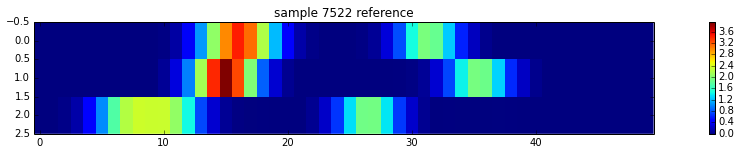

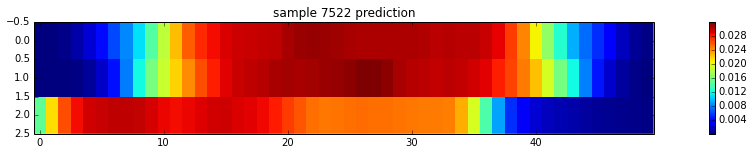

count_distr: [ 0.10055663  0.29279354  0.25236443  0.17316936  0.18111603] actual: 1


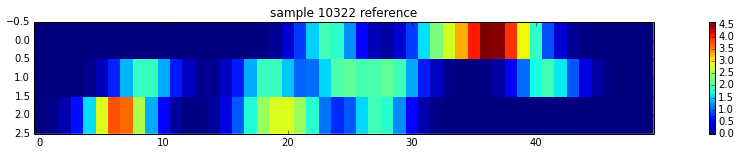

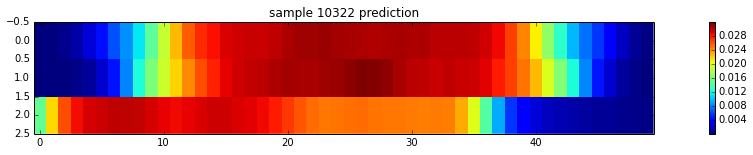

count_distr: [ 0.10032523  0.29348978  0.2506063   0.17390029  0.1816784 ] actual: 4


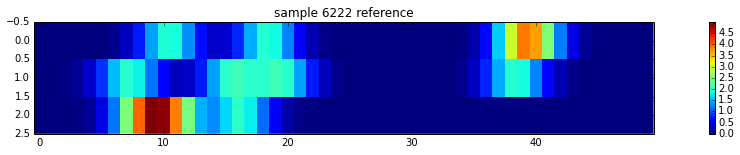

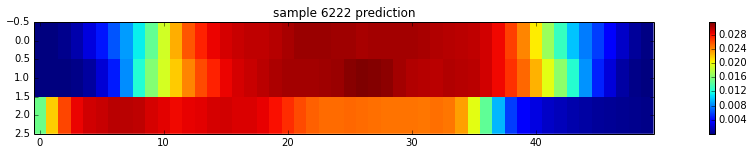

test score:
full loss: 155.354492188
detection loss: 155.304504395
count crossentropy 1.55290305614
l2 penalty: 0.0499820001423
pseudo-auc 0.716692827701
count-acc 0.285189268651

count_distr: [ 0.10067557  0.29100996  0.25103384  0.17379205  0.18348858] actual: 1


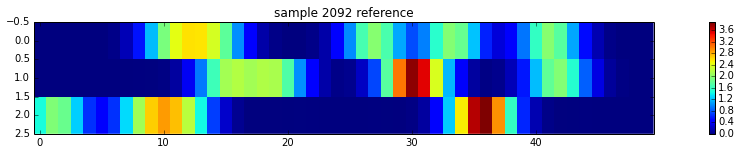

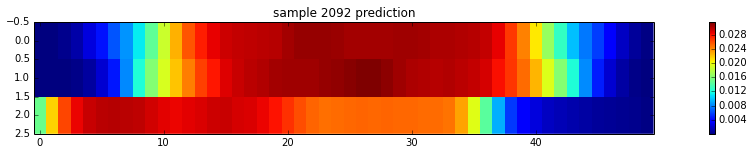

count_distr: [ 0.10323578  0.29170159  0.24868096  0.17314473  0.18323696] actual: 2


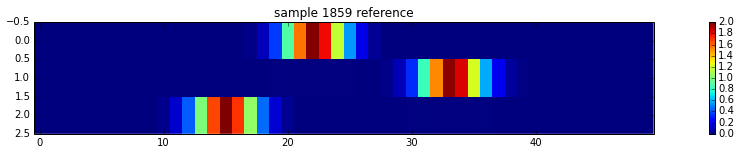

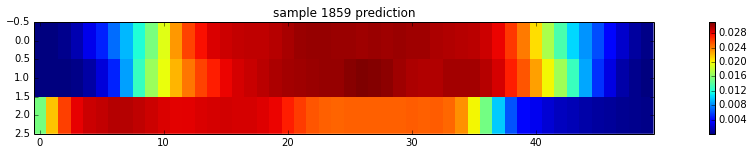

count_distr: [ 0.10165328  0.29178625  0.25129247  0.17300463  0.18226337] actual: 1


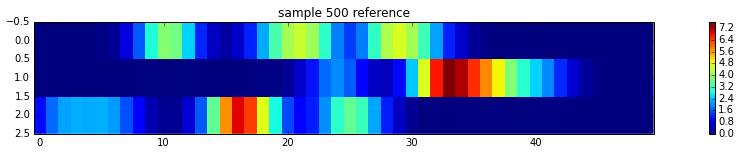

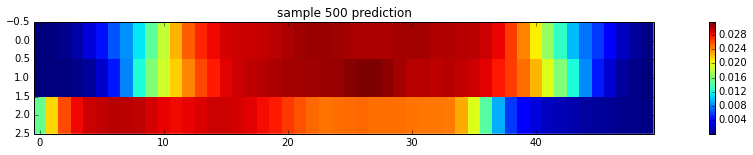

.........................
learning plots


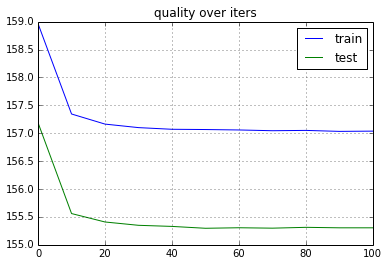

train loss during epoch 101 : 149.909363
train loss during epoch 101 : 151.437042
train loss during epoch 101 : 153.475021
train loss during epoch 101 : 154.813751
train loss during epoch 101 : 155.560349
train loss during epoch 101 : 154.791702
train loss during epoch 101 : 155.153915
train loss during epoch 101 : 156.059418
train loss during epoch 101 : 157.141388
train loss during epoch 101 : 157.972260
train loss during epoch 101 : 158.093338
train loss during epoch 101 : 158.048416
train loss during epoch 101 : 157.416138
train loss during epoch 101 : 157.434616
train loss during epoch 101 : 157.677979
train loss during epoch 101 : 157.280182
train loss during epoch 101 : 157.539291
train loss during epoch 101 : 156.853836
train loss during epoch 101 : 157.584763
train loss during epoch 101 : 157.599472
train loss during epoch 101 : 158.061951
train loss during epoch 101 : 158.250015
train loss during epoch 101 : 158.171402
train loss during epoch 101 : 158.063019
train loss durin

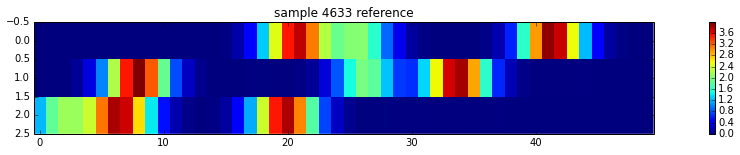

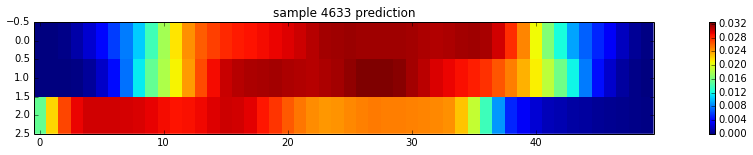

count_distr: [ 0.1017969   0.28924677  0.25930166  0.17043693  0.17921771] actual: 1


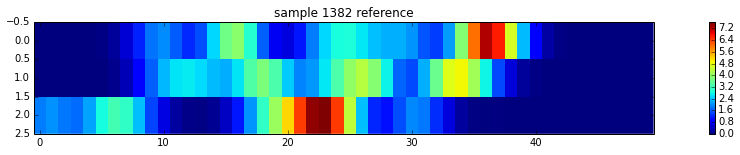

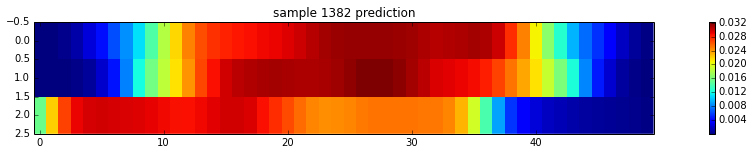

count_distr: [ 0.10021126  0.28886071  0.26053175  0.17173079  0.1786655 ] actual: 4


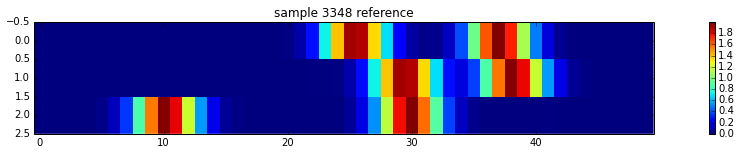

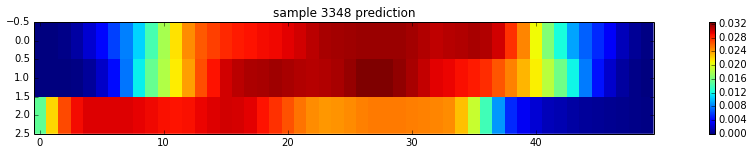

test score:
full loss: 155.36579895
detection loss: 155.315826416
count crossentropy 1.55362439156
l2 penalty: 0.0499745681882
pseudo-auc 0.716231002581
count-acc 0.285189268651

count_distr: [ 0.08432148  0.35093296  0.25194517  0.13653363  0.17626677] actual: 1


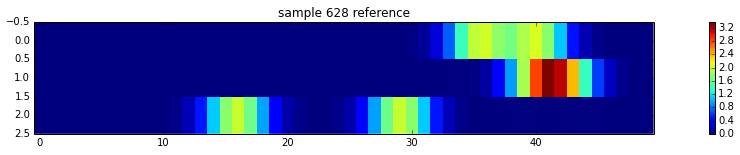

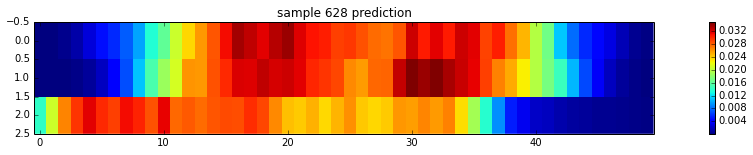

count_distr: [ 0.10070296  0.28919306  0.25901592  0.17097066  0.18011741] actual: 2


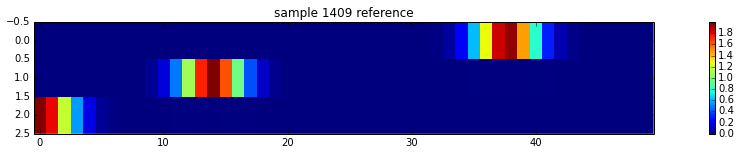

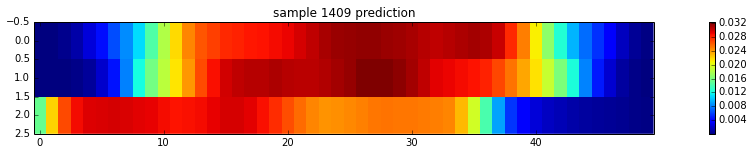

count_distr: [ 0.1023819   0.28864962  0.25645822  0.1710214   0.18148886] actual: 1


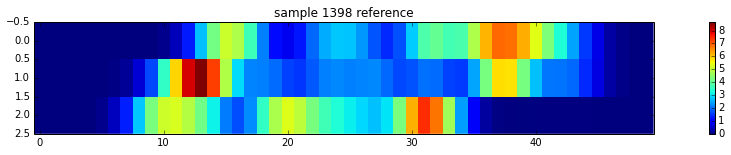

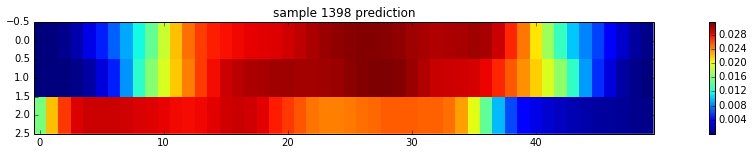

.........................
learning plots


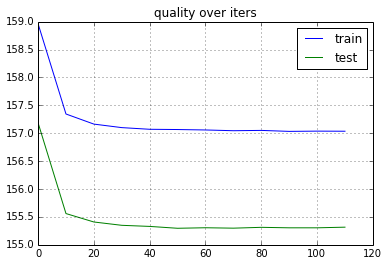

train loss during epoch 111 : 160.149750
train loss during epoch 111 : 161.439514
train loss during epoch 111 : 163.320236
train loss during epoch 111 : 159.052185
train loss during epoch 111 : 158.437515
train loss during epoch 111 : 158.398697
train loss during epoch 111 : 158.020020
train loss during epoch 111 : 159.058563
train loss during epoch 111 : 158.825165
train loss during epoch 111 : 158.319992
train loss during epoch 111 : 157.299515
train loss during epoch 111 : 157.640579
train loss during epoch 111 : 158.064758
train loss during epoch 111 : 157.991486
train loss during epoch 111 : 157.699280
train loss during epoch 111 : 157.928772
train loss during epoch 111 : 157.763565
train loss during epoch 111 : 158.159973
train loss during epoch 111 : 158.419357
train loss during epoch 111 : 158.020264
train loss during epoch 111 : 158.199783
train loss during epoch 111 : 158.305008
train loss during epoch 111 : 158.075745
train loss during epoch 111 : 158.154938
train loss durin

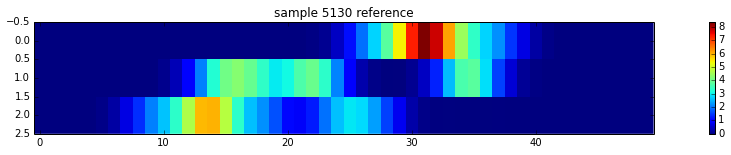

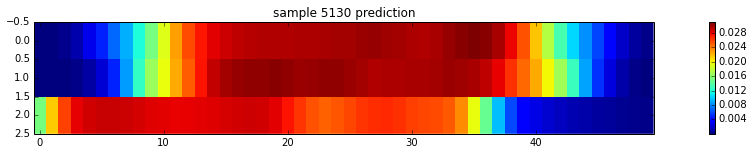

count_distr: [ 0.09969599  0.29970407  0.24989761  0.17053363  0.1801687 ] actual: 1


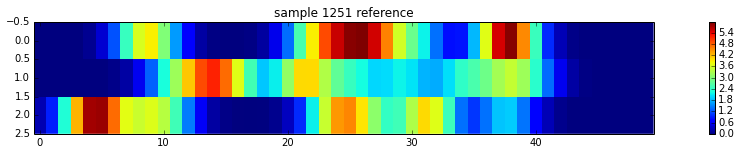

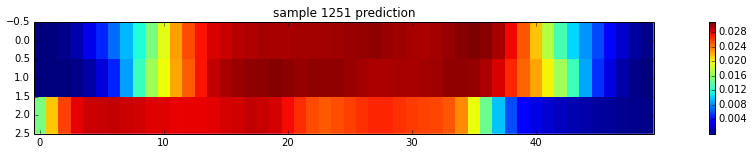

count_distr: [ 0.09945947  0.30070472  0.2511974   0.17073274  0.17790569] actual: 4


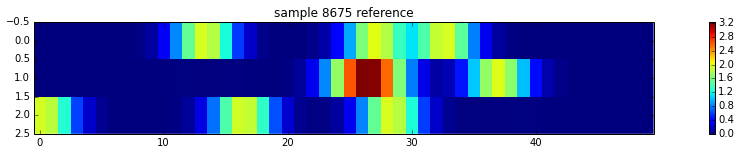

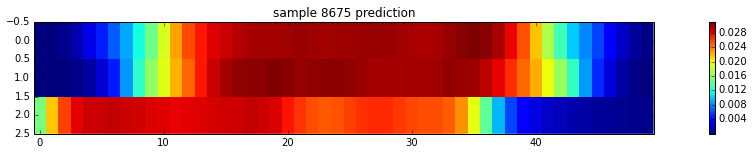

test score:
full loss: 155.352081299
detection loss: 155.302108765
count crossentropy 1.55252158642
l2 penalty: 0.0499671064317
pseudo-auc 0.715912035972
count-acc 0.285189268651

count_distr: [ 0.10068452  0.31047821  0.24681191  0.16155472  0.18047065] actual: 1


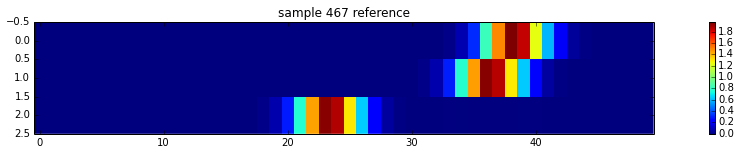

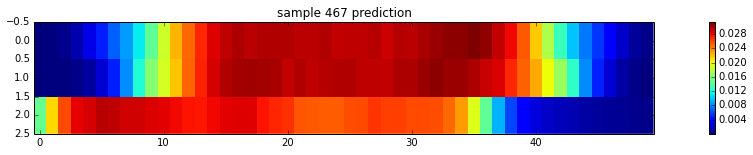

count_distr: [ 0.09931397  0.31421217  0.24328624  0.16803725  0.17515038] actual: 2


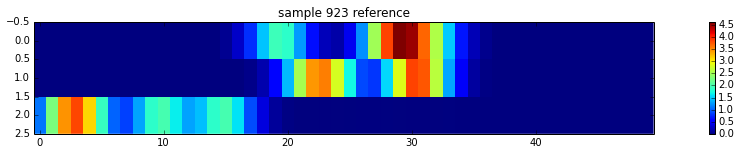

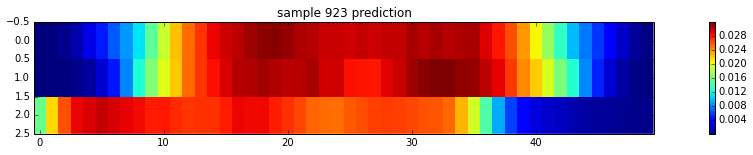

count_distr: [ 0.09954688  0.30124614  0.25137109  0.17111629  0.17671962] actual: 1


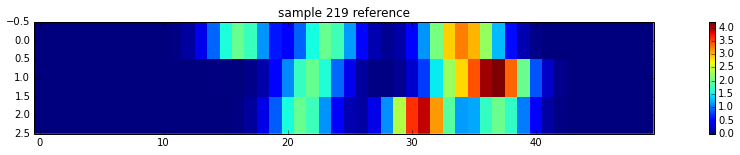

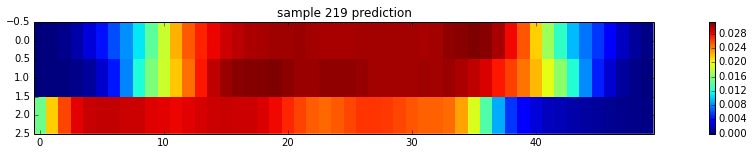

.........................
learning plots


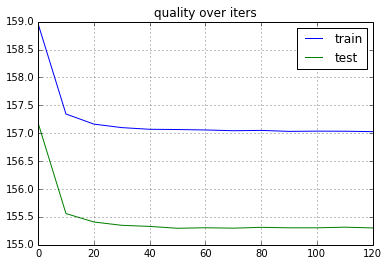

train loss during epoch 121 : 155.070618
train loss during epoch 121 : 155.950012
train loss during epoch 121 : 154.602921
train loss during epoch 121 : 155.400818
train loss during epoch 121 : 156.188873
train loss during epoch 121 : 157.796021
train loss during epoch 121 : 157.463058
train loss during epoch 121 : 158.571045
train loss during epoch 121 : 157.745682
train loss during epoch 121 : 157.525925
train loss during epoch 121 : 157.258591
train loss during epoch 121 : 156.429733
train loss during epoch 121 : 156.707581
train loss during epoch 121 : 156.105637
train loss during epoch 121 : 155.741165
train loss during epoch 121 : 155.726288
train loss during epoch 121 : 155.511383
train loss during epoch 121 : 155.595154
train loss during epoch 121 : 155.701691
train loss during epoch 121 : 155.724640
train loss during epoch 121 : 156.250397
train loss during epoch 121 : 156.496323
train loss during epoch 121 : 156.319443
train loss during epoch 121 : 156.241135
train loss durin

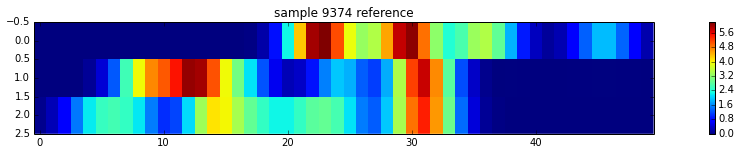

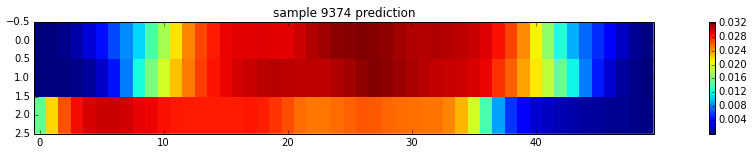

count_distr: [ 0.09784709  0.29786801  0.26036683  0.17001337  0.1739047 ] actual: 1


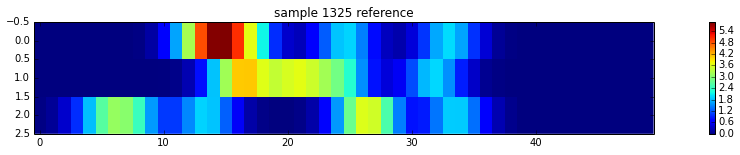

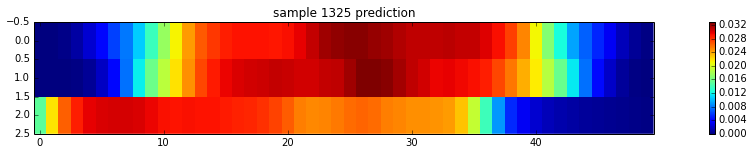

count_distr: [ 0.09712766  0.29795894  0.25753433  0.17072733  0.17665173] actual: 4


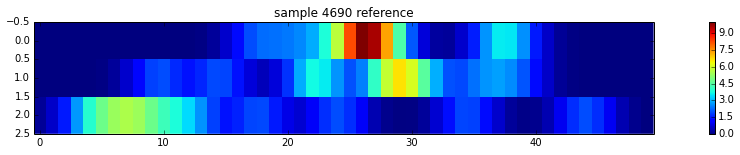

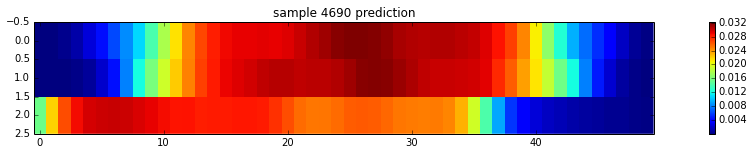

test score:
full loss: 155.364761353
detection loss: 155.314804077
count crossentropy 1.55164527893
l2 penalty: 0.0499599948525
pseudo-auc 0.716763207395
count-acc 0.285189268651

count_distr: [ 0.09950013  0.29527804  0.25718087  0.17050907  0.17753191] actual: 1


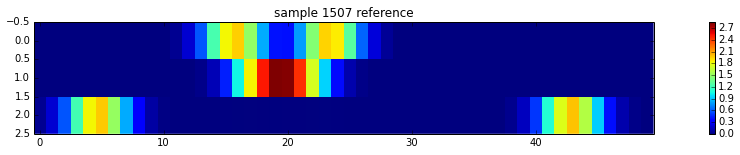

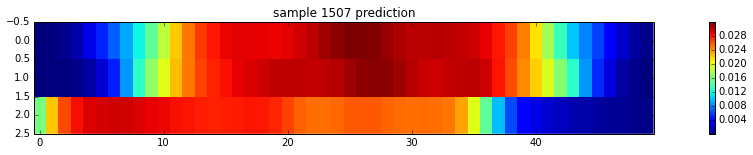

count_distr: [ 0.10243265  0.2947      0.25864407  0.16822559  0.17599769] actual: 2


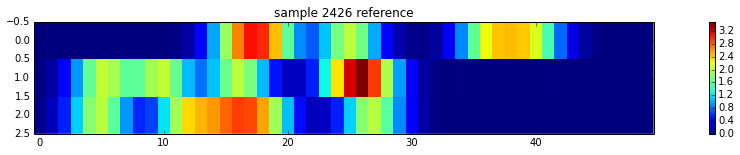

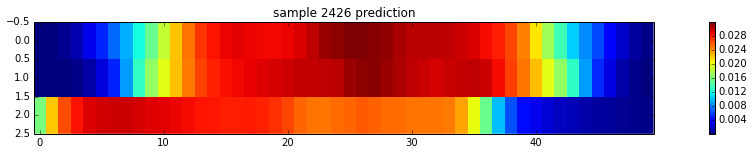

count_distr: [ 0.1051387   0.29549187  0.25392646  0.16632524  0.17911771] actual: 1


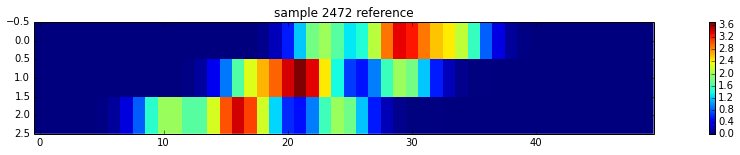

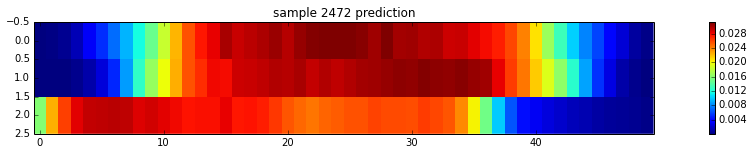

.........................
learning plots


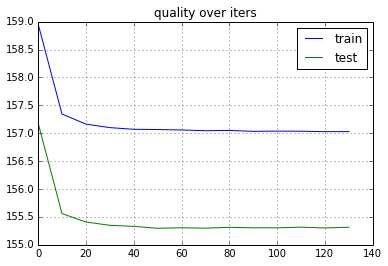

train loss during epoch 131 : 177.308243
train loss during epoch 131 : 163.339432
train loss during epoch 131 : 158.682983
train loss during epoch 131 : 160.416138
train loss during epoch 131 : 160.632584
train loss during epoch 131 : 159.663315
train loss during epoch 131 : 158.811295
train loss during epoch 131 : 158.806503
train loss during epoch 131 : 158.672974
train loss during epoch 131 : 158.388596
train loss during epoch 131 : 158.682800
train loss during epoch 131 : 157.830994
train loss during epoch 131 : 157.719223
train loss during epoch 131 : 158.332657
train loss during epoch 131 : 158.776367
train loss during epoch 131 : 158.551315
train loss during epoch 131 : 158.407166
train loss during epoch 131 : 158.475601
train loss during epoch 131 : 157.894028
train loss during epoch 131 : 157.825333
train loss during epoch 131 : 157.943283
train loss during epoch 131 : 157.523422
train loss during epoch 131 : 157.796326
train loss during epoch 131 : 158.148697
train loss durin

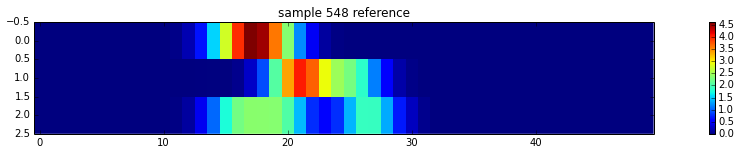

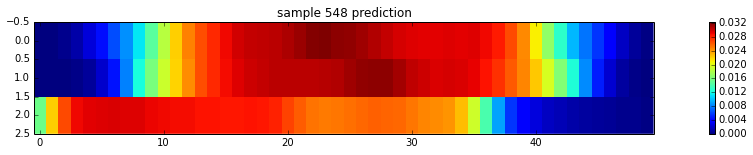

count_distr: [ 0.10140422  0.2925477   0.25868735  0.16903196  0.17832877] actual: 1


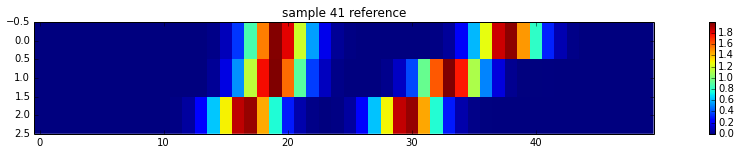

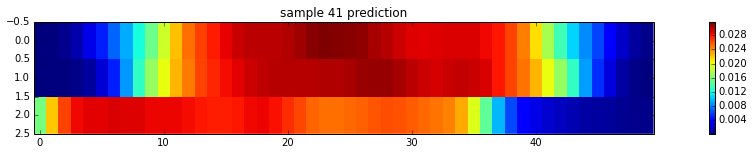

count_distr: [ 0.10431091  0.29583794  0.25718459  0.16557606  0.17709048] actual: 4


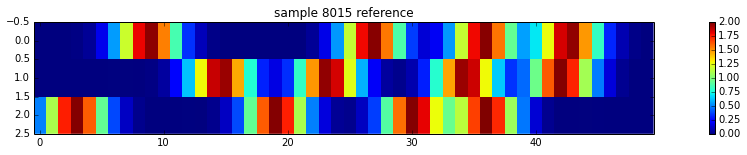

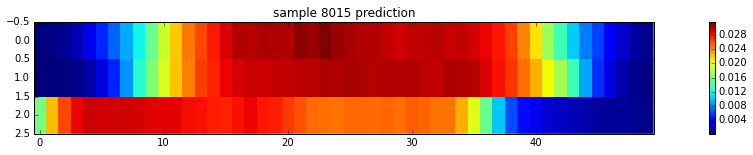

test score:
full loss: 155.362014771
detection loss: 155.312057495
count crossentropy 1.55421459675
l2 penalty: 0.049953032285
pseudo-auc 0.716913944846
count-acc 0.285189268651

count_distr: [ 0.09949396  0.31098825  0.25536352  0.16090722  0.17324705] actual: 1


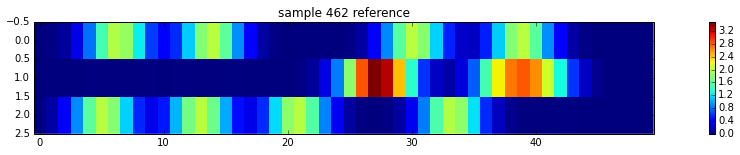

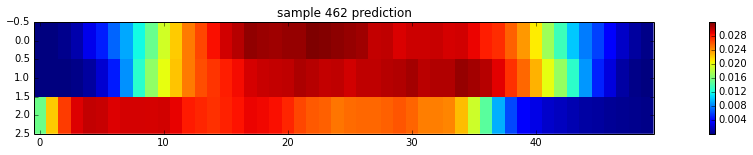

count_distr: [ 0.10081724  0.29447606  0.25768295  0.16930516  0.17771859] actual: 2


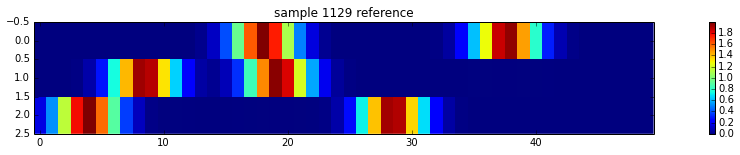

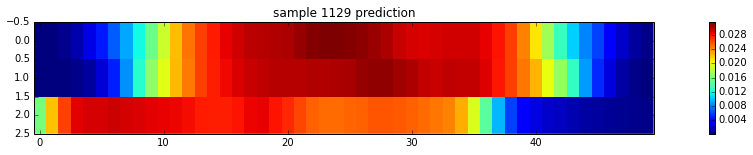

count_distr: [ 0.10409246  0.29822317  0.25615516  0.1638346   0.1776946 ] actual: 1


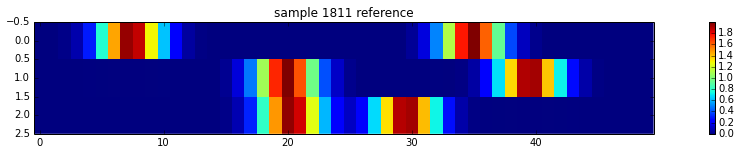

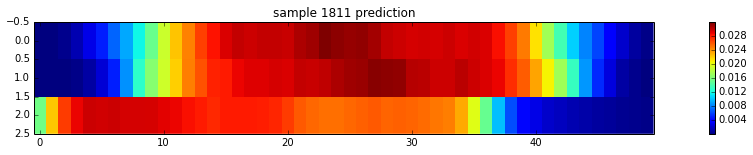

.........................
learning plots


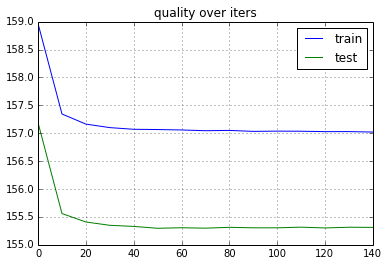

train loss during epoch 141 : 149.761688
train loss during epoch 141 : 155.317841
train loss during epoch 141 : 159.484924
train loss during epoch 141 : 159.662109
train loss during epoch 141 : 158.965469
train loss during epoch 141 : 159.635956
train loss during epoch 141 : 158.348129
train loss during epoch 141 : 158.907150
train loss during epoch 141 : 157.967697
train loss during epoch 141 : 158.525452
train loss during epoch 141 : 158.458237
train loss during epoch 141 : 157.982849
train loss during epoch 141 : 158.598007
train loss during epoch 141 : 158.464508
train loss during epoch 141 : 158.488342
train loss during epoch 141 : 158.764008
train loss during epoch 141 : 158.814713
train loss during epoch 141 : 158.569550
train loss during epoch 141 : 158.184006
train loss during epoch 141 : 158.031540
train loss during epoch 141 : 158.336029
train loss during epoch 141 : 157.799133
train loss during epoch 141 : 157.930634
train loss during epoch 141 : 157.122421
train loss durin

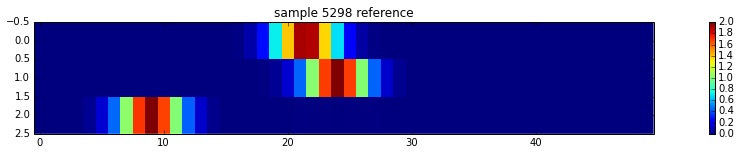

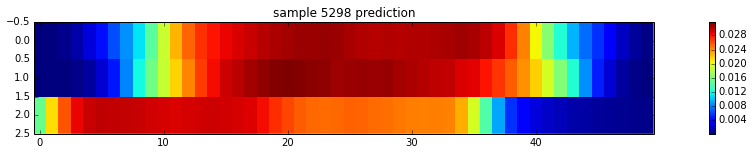

count_distr: [ 0.09990767  0.28940779  0.25504547  0.17672321  0.17891586] actual: 1


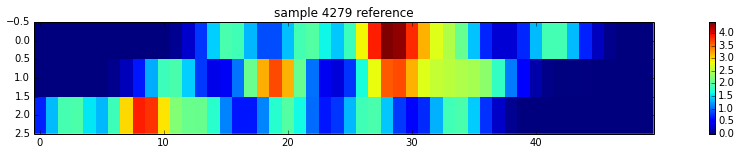

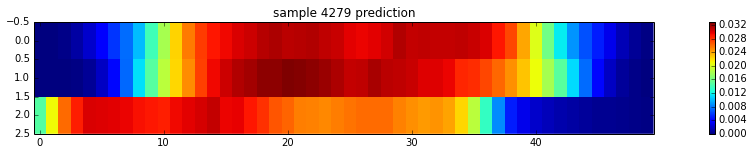

count_distr: [ 0.09646745  0.29119611  0.25519717  0.17610426  0.18103501] actual: 4


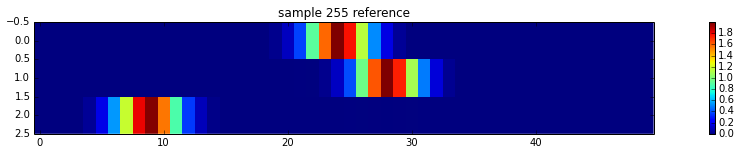

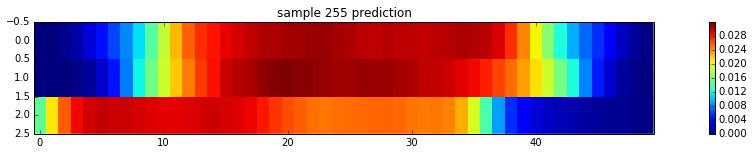

test score:
full loss: 155.356689453
detection loss: 155.306762695
count crossentropy 1.55233001709
l2 penalty: 0.0499463751912
pseudo-auc 0.716289911596
count-acc 0.285189268651

count_distr: [ 0.09681214  0.2933712   0.25460163  0.1758136   0.17940144] actual: 1


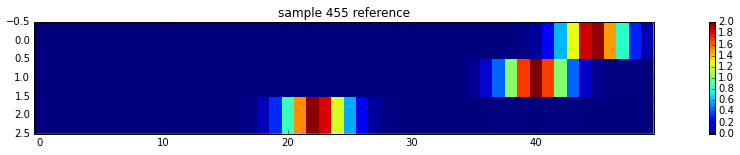

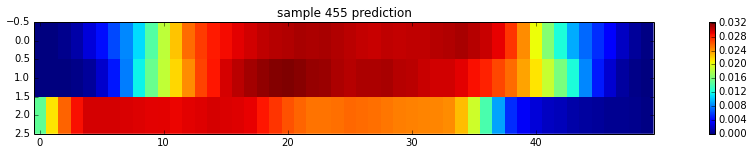

count_distr: [ 0.09728623  0.29660153  0.25352928  0.17209807  0.18048491] actual: 2


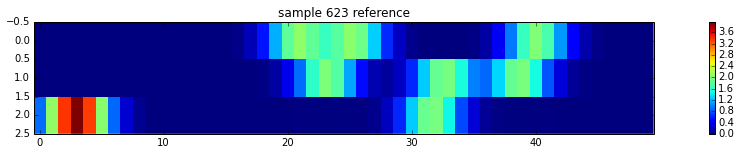

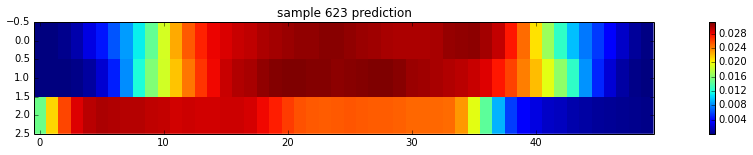

count_distr: [ 0.09397808  0.29437587  0.25511378  0.17457259  0.18195967] actual: 1


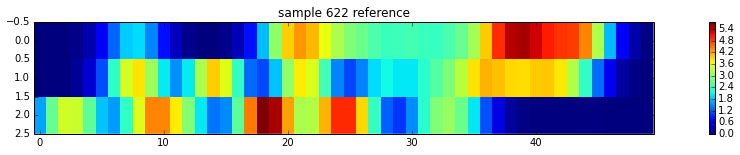

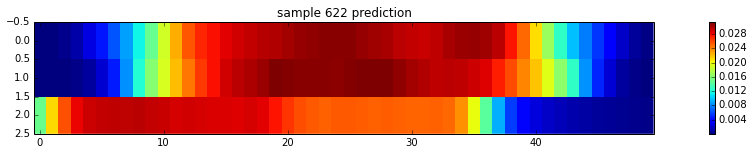

.........................
learning plots


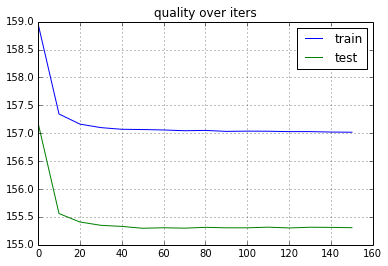

train loss during epoch 151 : 162.111176
train loss during epoch 151 : 155.229767
train loss during epoch 151 : 155.273361
train loss during epoch 151 : 158.420532
train loss during epoch 151 : 158.567886
train loss during epoch 151 : 159.151474
train loss during epoch 151 : 158.759750
train loss during epoch 151 : 158.238571
train loss during epoch 151 : 158.258316
train loss during epoch 151 : 158.102753
train loss during epoch 151 : 158.545914
train loss during epoch 151 : 159.465515
train loss during epoch 151 : 159.812576
train loss during epoch 151 : 159.271164
train loss during epoch 151 : 159.282455
train loss during epoch 151 : 159.407333
train loss during epoch 151 : 158.444153
train loss during epoch 151 : 158.822357
train loss during epoch 151 : 158.943100
train loss during epoch 151 : 158.762650
train loss during epoch 151 : 158.726883
train loss during epoch 151 : 158.378601
train loss during epoch 151 : 158.531906
train loss during epoch 151 : 158.015457
train loss durin

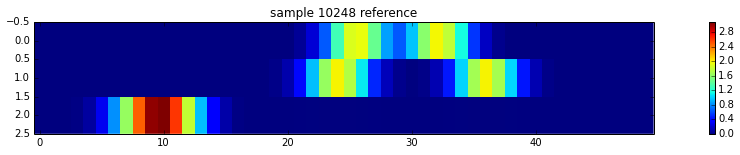

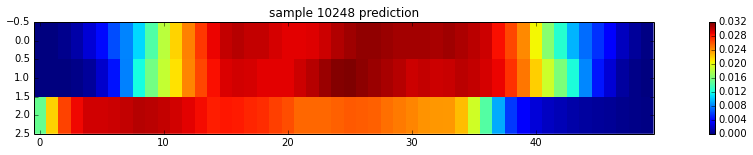

count_distr: [ 0.10318606  0.29162273  0.255142    0.16917616  0.18087305] actual: 1


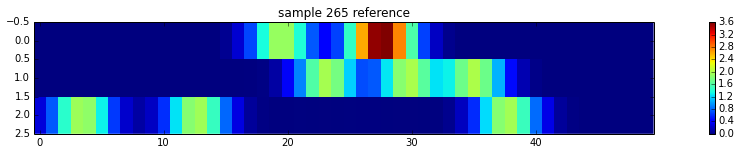

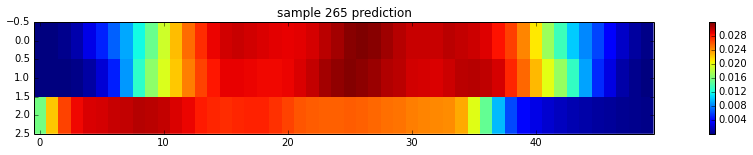

count_distr: [ 0.10136931  0.28805789  0.25465316  0.17386933  0.18205033] actual: 4


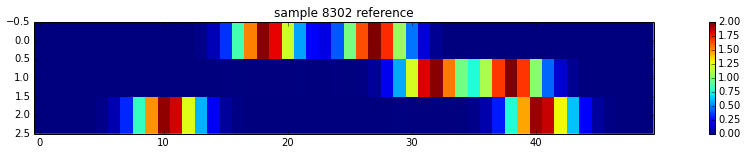

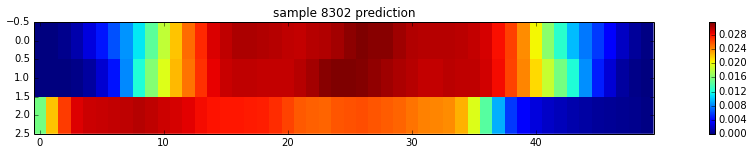

test score:
full loss: 155.367401123
detection loss: 155.317459106
count crossentropy 1.55329692364
l2 penalty: 0.0499399751425
pseudo-auc 0.717009861564
count-acc 0.285189268651

count_distr: [ 0.09603766  0.28928858  0.25361013  0.17519401  0.1858696 ] actual: 1


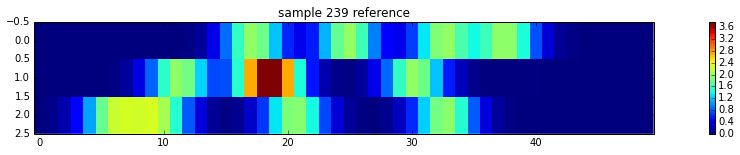

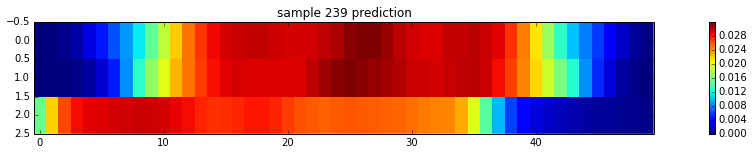

count_distr: [ 0.100766    0.30122897  0.25466877  0.16950727  0.173829  ] actual: 2


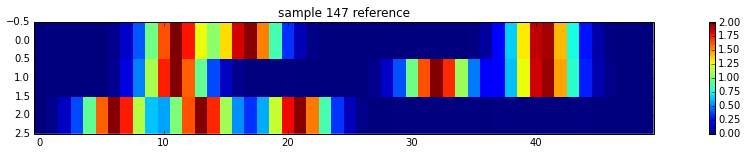

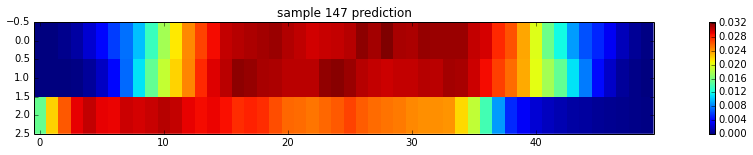

count_distr: [ 0.09941023  0.28808287  0.25792259  0.17398857  0.18059577] actual: 1


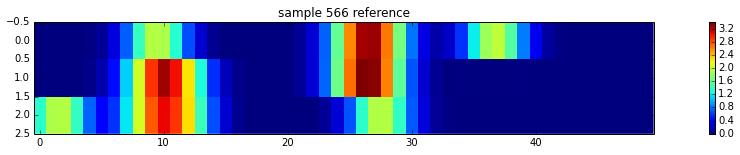

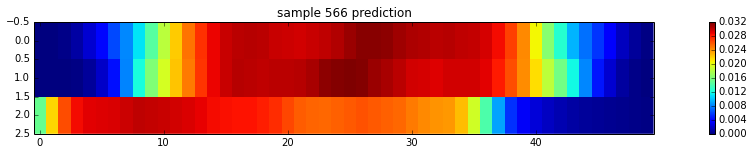

.........................
learning plots


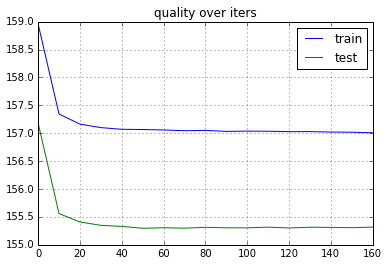

train loss during epoch 161 : 152.608551
train loss during epoch 161 : 160.473480
train loss during epoch 161 : 157.865280
train loss during epoch 161 : 158.596558
train loss during epoch 161 : 157.666107
train loss during epoch 161 : 157.418930
train loss during epoch 161 : 156.910568
train loss during epoch 161 : 156.898865
train loss during epoch 161 : 156.393753
train loss during epoch 161 : 155.968948
train loss during epoch 161 : 156.100418
train loss during epoch 161 : 155.890793
train loss during epoch 161 : 155.789398
train loss during epoch 161 : 155.865753
train loss during epoch 161 : 155.506821
train loss during epoch 161 : 155.506180
train loss during epoch 161 : 155.545822
train loss during epoch 161 : 155.540680
train loss during epoch 161 : 155.822708
train loss during epoch 161 : 156.192474
train loss during epoch 161 : 155.451126
train loss during epoch 161 : 155.986237
train loss during epoch 161 : 155.294022
train loss during epoch 161 : 155.282349
train loss durin

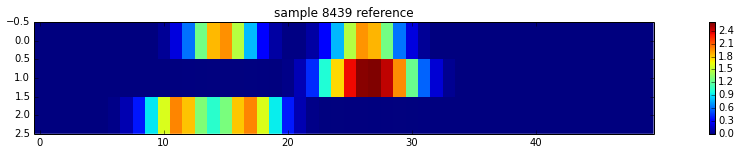

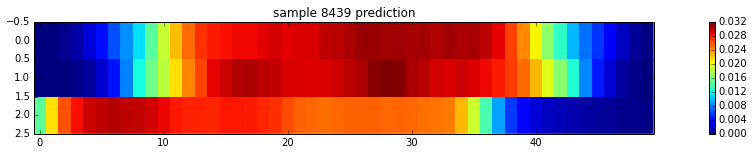

count_distr: [ 0.1032237   0.29237607  0.24700433  0.17680265  0.18059324] actual: 1


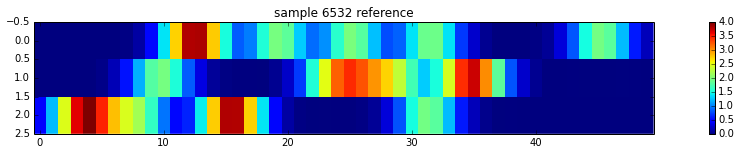

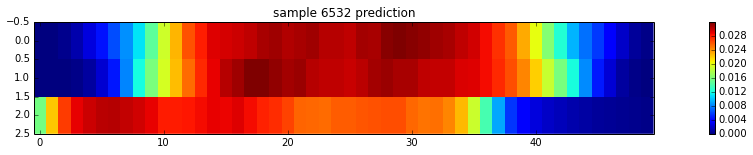

count_distr: [ 0.09868477  0.29315817  0.25202098  0.17378981  0.18234624] actual: 4


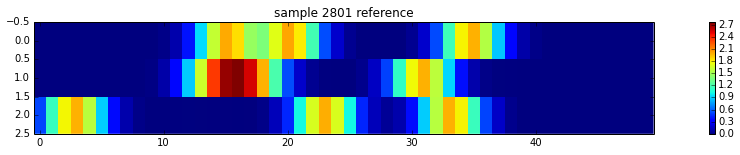

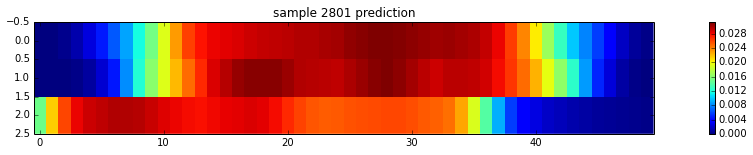

test score:
full loss: 155.35295105
detection loss: 155.303024292
count crossentropy 1.55314981937
l2 penalty: 0.04993378371
pseudo-auc 0.716394984667
count-acc 0.285189268651

count_distr: [ 0.09948184  0.29709807  0.25194076  0.17024703  0.18123227] actual: 1


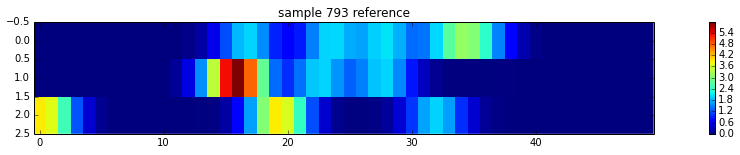

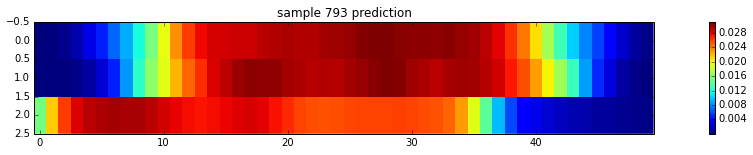

count_distr: [ 0.10089542  0.3045339   0.24929102  0.16711797  0.1781617 ] actual: 2


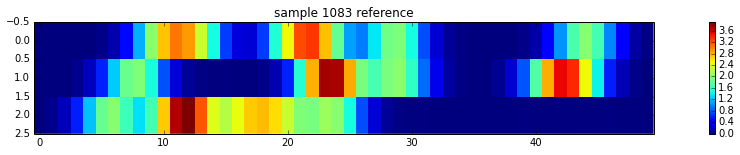

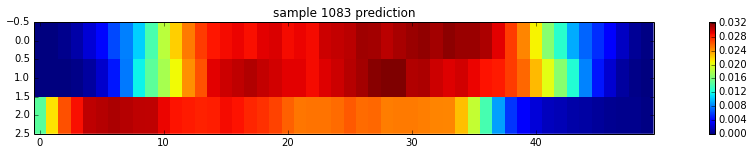

count_distr: [ 0.10232474  0.30842054  0.23931478  0.16669554  0.18324439] actual: 1


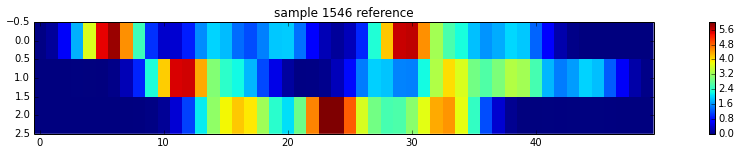

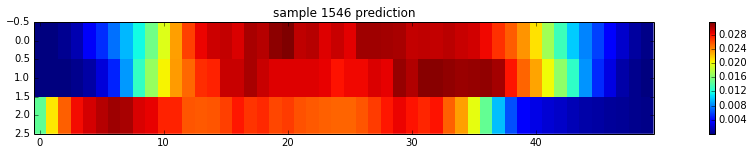

.........................
learning plots


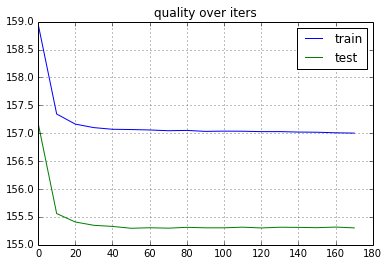

train loss during epoch 171 : 148.613922
train loss during epoch 171 : 154.021790
train loss during epoch 171 : 155.343216
train loss during epoch 171 : 155.857117
train loss during epoch 171 : 155.013794
train loss during epoch 171 : 154.390274
train loss during epoch 171 : 155.070709
train loss during epoch 171 : 153.617401
train loss during epoch 171 : 154.028442
train loss during epoch 171 : 153.883362
train loss during epoch 171 : 155.404846
train loss during epoch 171 : 156.739578
train loss during epoch 171 : 156.695389
train loss during epoch 171 : 156.801636
train loss during epoch 171 : 156.470139
train loss during epoch 171 : 155.995117
train loss during epoch 171 : 156.092865
train loss during epoch 171 : 155.667557
train loss during epoch 171 : 155.834412
train loss during epoch 171 : 156.266846
train loss during epoch 171 : 156.702942
train loss during epoch 171 : 156.998459
train loss during epoch 171 : 156.819855
train loss during epoch 171 : 157.006638
train loss durin

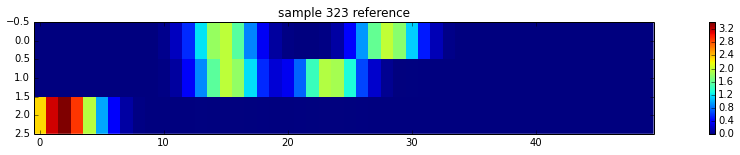

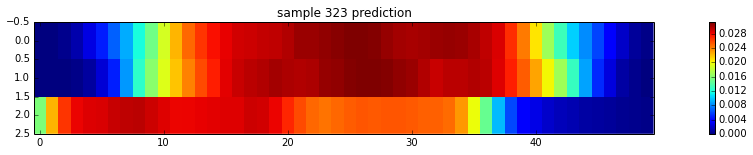

count_distr: [ 0.09664395  0.30390036  0.25736728  0.14405598  0.19803244] actual: 1


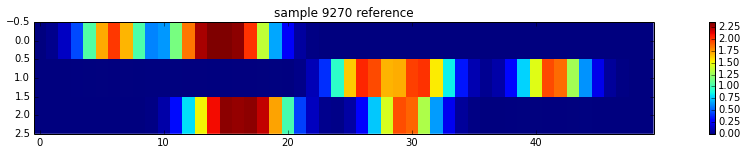

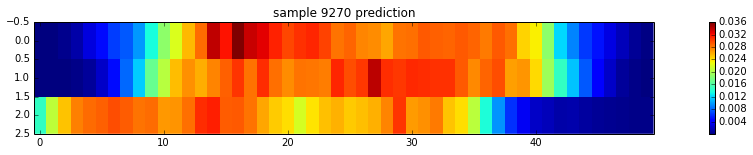

count_distr: [ 0.09952627  0.29645124  0.25518507  0.16930589  0.17953153] actual: 4


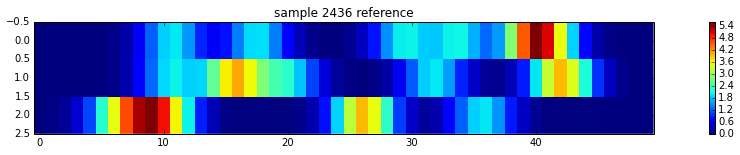

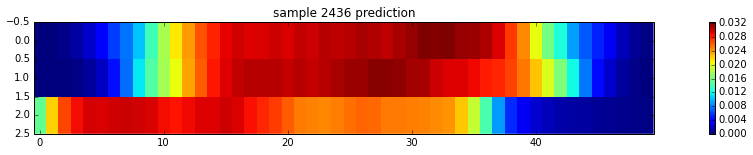

test score:
full loss: 155.352661133
detection loss: 155.302734375
count crossentropy 1.55373001099
l2 penalty: 0.0499279759824
pseudo-auc 0.716692149717
count-acc 0.285189268651

count_distr: [ 0.09910101  0.29137832  0.25753668  0.17027822  0.18170576] actual: 1


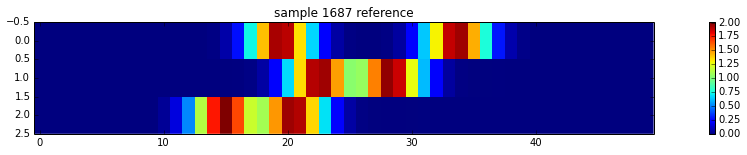

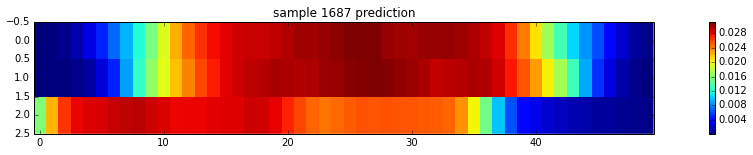

count_distr: [ 0.0958393   0.28919175  0.25788125  0.17397144  0.18311624] actual: 2


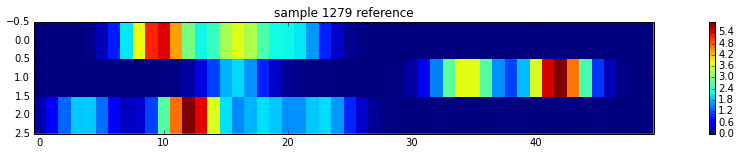

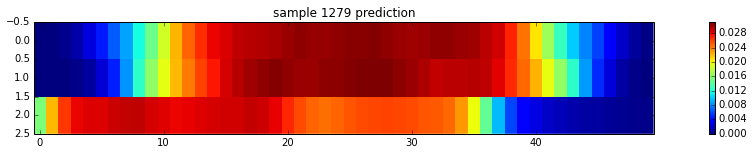

count_distr: [ 0.10111118  0.30308679  0.25616094  0.16199696  0.17764413] actual: 1


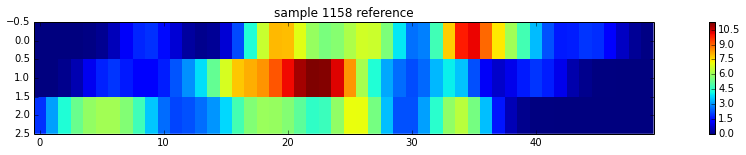

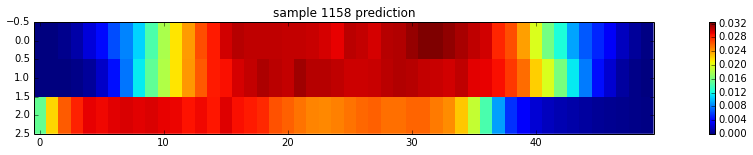

.........................
learning plots


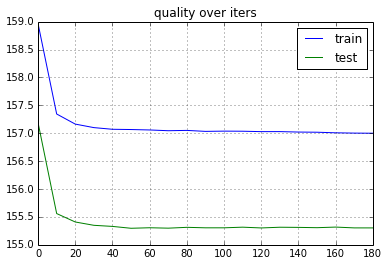

train loss during epoch 181 : 161.585922
train loss during epoch 181 : 159.635254
train loss during epoch 181 : 157.601913
train loss during epoch 181 : 155.917923
train loss during epoch 181 : 156.706924
train loss during epoch 181 : 158.186813
train loss during epoch 181 : 157.929489
train loss during epoch 181 : 155.849152
train loss during epoch 181 : 154.895203
train loss during epoch 181 : 154.599823
train loss during epoch 181 : 153.675842
train loss during epoch 181 : 153.498718
train loss during epoch 181 : 153.933289
train loss during epoch 181 : 154.765717
train loss during epoch 181 : 154.945526
train loss during epoch 181 : 154.710876
train loss during epoch 181 : 154.212738
train loss during epoch 181 : 154.699890
train loss during epoch 181 : 154.591049
train loss during epoch 181 : 155.023590
train loss during epoch 181 : 155.322723
train loss during epoch 181 : 155.299530
train loss during epoch 181 : 155.243011
train loss during epoch 181 : 155.279556
train loss durin

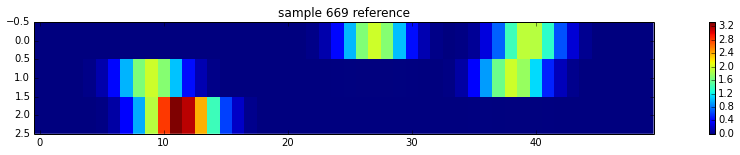

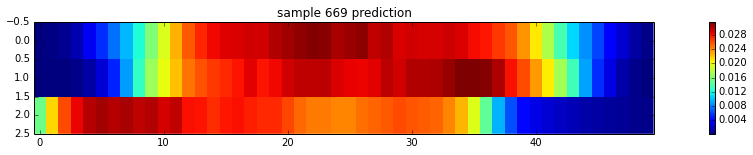

count_distr: [ 0.08835832  0.28876573  0.29128712  0.1418618   0.18972702] actual: 1


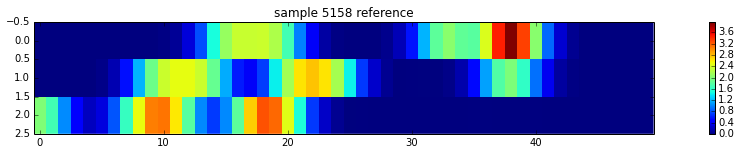

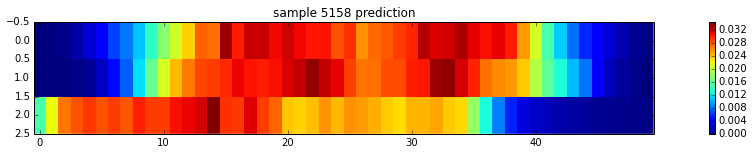

count_distr: [ 0.0977605   0.29471964  0.25058261  0.17363429  0.18330295] actual: 4


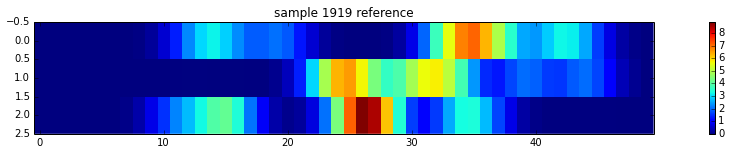

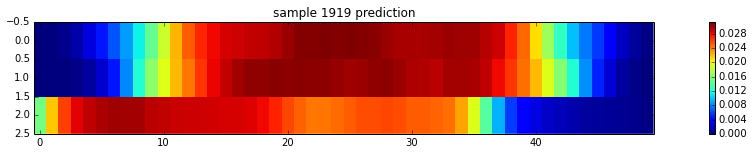

test score:
full loss: 155.360824585
detection loss: 155.310897827
count crossentropy 1.55434954166
l2 penalty: 0.0499222949147
pseudo-auc 0.71661632791
count-acc 0.285189268651

count_distr: [ 0.09548222  0.29779547  0.24944571  0.17332567  0.18395093] actual: 1


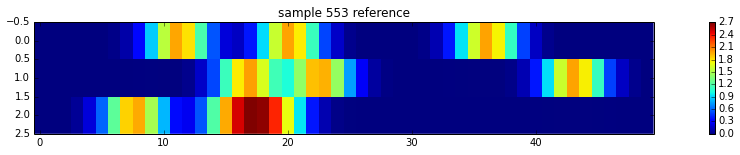

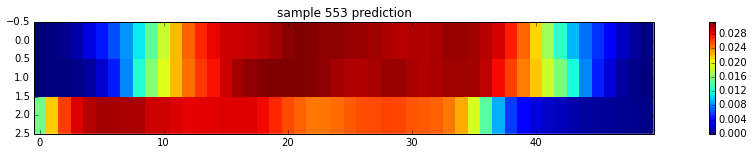

count_distr: [ 0.09898999  0.29584798  0.25253162  0.17056766  0.18206276] actual: 2


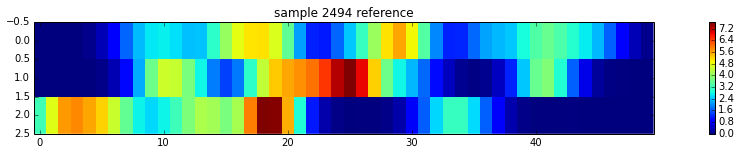

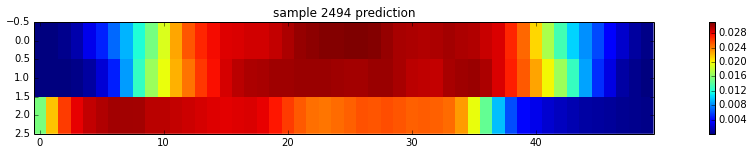

count_distr: [ 0.0998893   0.29646805  0.25012258  0.17638481  0.17713527] actual: 1


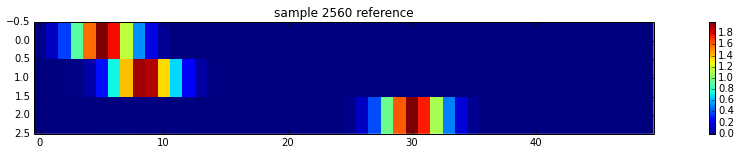

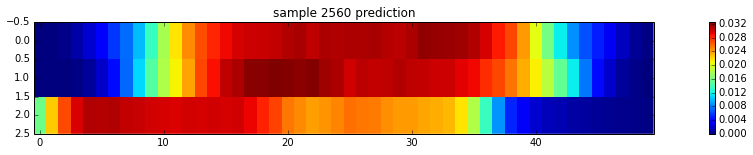

.........................
learning plots


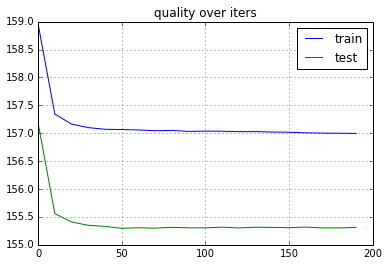

train loss during epoch 191 : 150.742645
train loss during epoch 191 : 154.153595
train loss during epoch 191 : 153.776108
train loss during epoch 191 : 153.441299
train loss during epoch 191 : 155.969635
train loss during epoch 191 : 156.631348
train loss during epoch 191 : 157.047256
train loss during epoch 191 : 158.172882
train loss during epoch 191 : 158.717270
train loss during epoch 191 : 158.194305
train loss during epoch 191 : 157.765396
train loss during epoch 191 : 157.626083
train loss during epoch 191 : 157.936020
train loss during epoch 191 : 157.665604
train loss during epoch 191 : 157.455597
train loss during epoch 191 : 157.686005
train loss during epoch 191 : 158.053711
train loss during epoch 191 : 157.857239
train loss during epoch 191 : 158.122543
train loss during epoch 191 : 158.235443
train loss during epoch 191 : 158.305145
train loss during epoch 191 : 158.037048
train loss during epoch 191 : 157.774185
train loss during epoch 191 : 157.305344
train loss durin

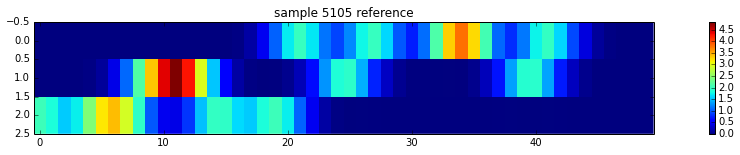

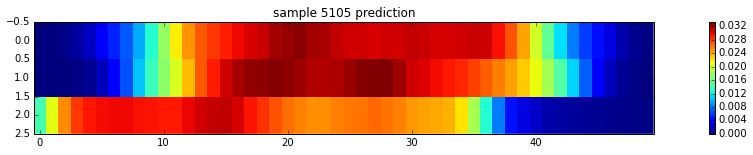

count_distr: [ 0.09852414  0.2868363   0.2608912   0.17288774  0.18086062] actual: 1


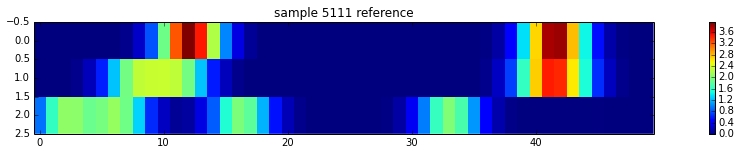

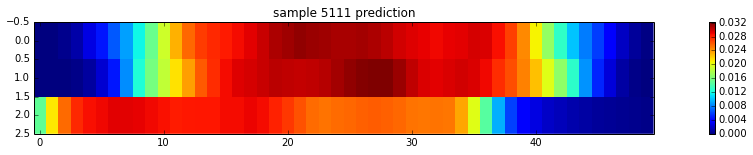

count_distr: [ 0.10033858  0.29677796  0.25224075  0.17167038  0.17897232] actual: 4


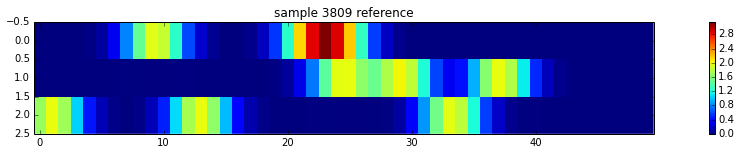

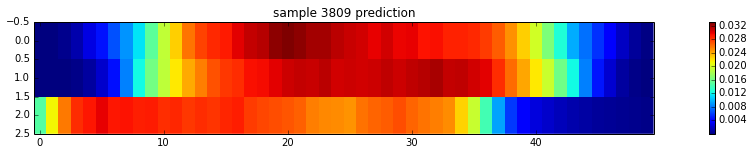

test score:
full loss: 155.372680664
detection loss: 155.322769165
count crossentropy 1.5503834486
l2 penalty: 0.0499170310795
pseudo-auc 0.716458794944
count-acc 0.284454244763

count_distr: [ 0.09993418  0.27497467  0.25325951  0.18992896  0.18190266] actual: 1


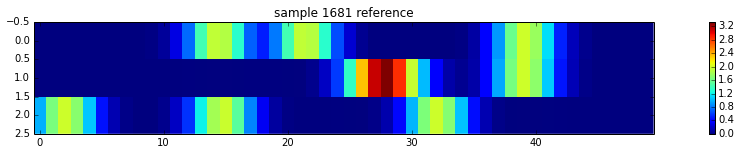

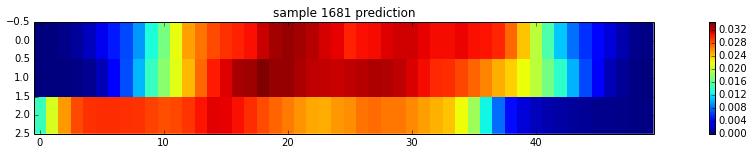

count_distr: [ 0.09867027  0.28163975  0.25765377  0.17662996  0.18540624] actual: 2


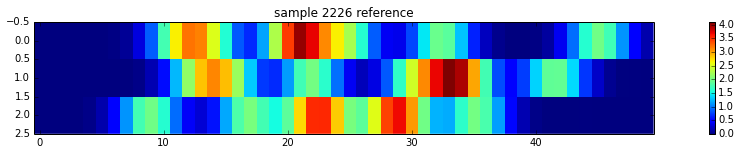

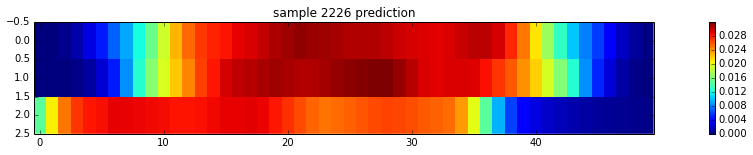

count_distr: [ 0.10188371  0.28268045  0.25840175  0.17483233  0.18220176] actual: 1


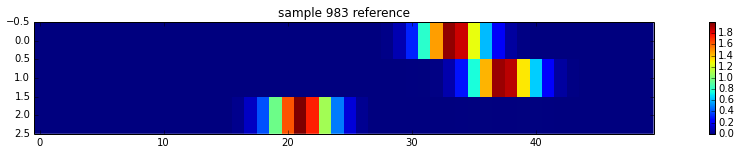

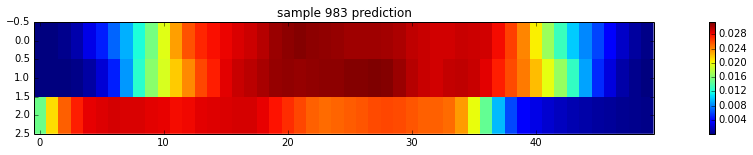

.........................
learning plots


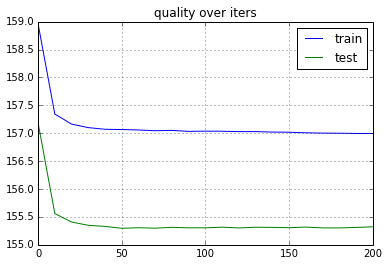

train loss during epoch 201 : 158.307007
train loss during epoch 201 : 158.360703
train loss during epoch 201 : 158.315247
train loss during epoch 201 : 158.485870
train loss during epoch 201 : 159.770660
train loss during epoch 201 : 159.199631
train loss during epoch 201 : 158.587982
train loss during epoch 201 : 158.036240
train loss during epoch 201 : 157.938995
train loss during epoch 201 : 158.393707
train loss during epoch 201 : 157.995499
train loss during epoch 201 : 157.379120
train loss during epoch 201 : 156.686218
train loss during epoch 201 : 155.939438
train loss during epoch 201 : 155.716736
train loss during epoch 201 : 155.899902
train loss during epoch 201 : 156.047241
train loss during epoch 201 : 156.406250
train loss during epoch 201 : 156.537994
train loss during epoch 201 : 156.289505
train loss during epoch 201 : 156.039505
train loss during epoch 201 : 156.118759
train loss during epoch 201 : 155.982010
train loss during epoch 201 : 155.809814
train loss durin

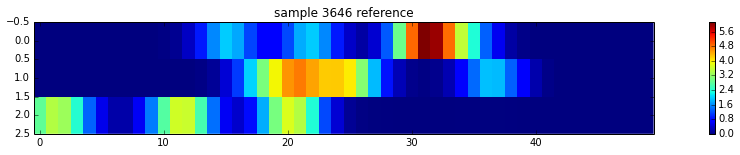

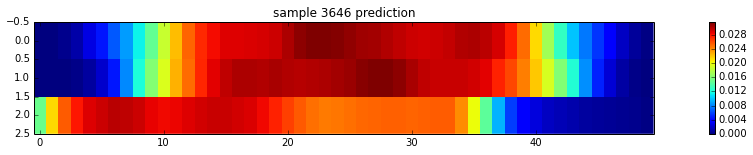

count_distr: [ 0.09818169  0.28802973  0.25863403  0.17135353  0.18380103] actual: 1


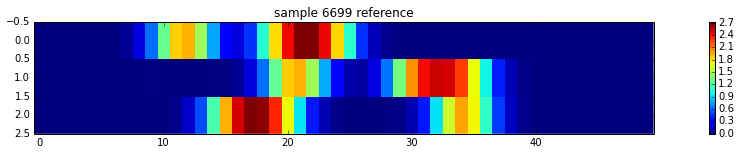

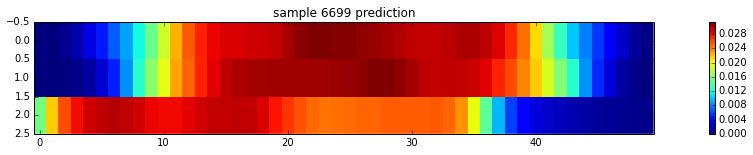

count_distr: [ 0.09704675  0.29442716  0.26291859  0.16833834  0.17726915] actual: 4


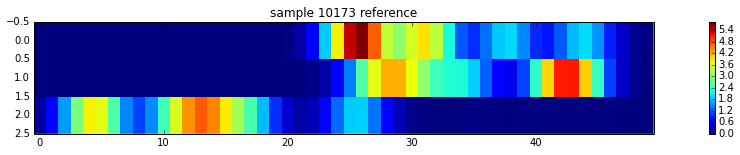

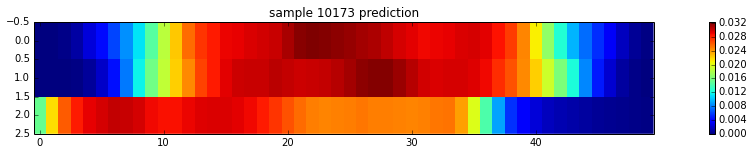

test score:
full loss: 155.3621521
detection loss: 155.312240601
count crossentropy 1.55328333378
l2 penalty: 0.0499119460583
pseudo-auc 0.71670945078
count-acc 0.284086732819

count_distr: [ 0.09972827  0.28323326  0.25688311  0.17553841  0.18461695] actual: 1


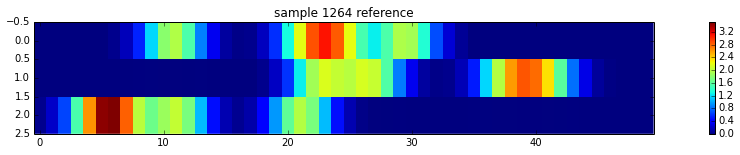

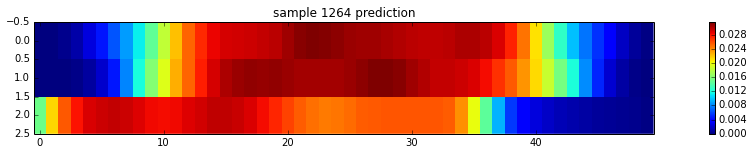

count_distr: [ 0.10145625  0.28960547  0.2638987   0.16633686  0.1787027 ] actual: 2


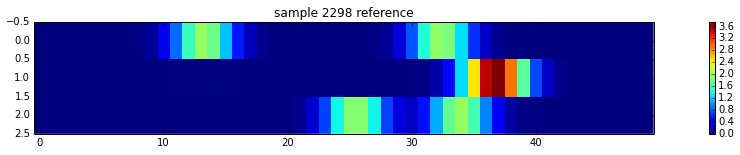

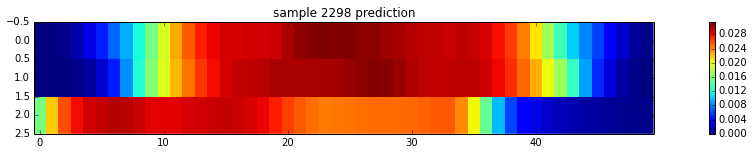

count_distr: [ 0.09659482  0.28725737  0.25939584  0.17367758  0.1830744 ] actual: 1


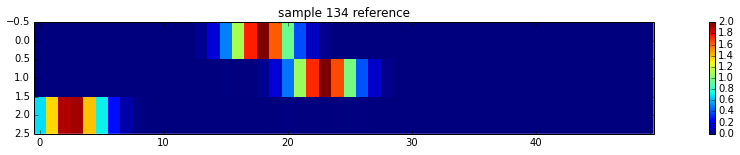

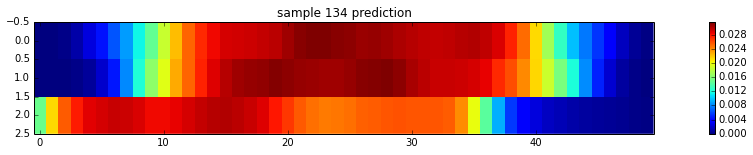

.........................
learning plots


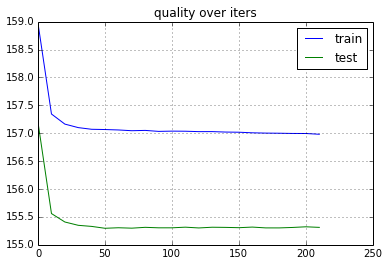

train loss during epoch 211 : 156.878967
train loss during epoch 211 : 158.002792
train loss during epoch 211 : 157.738235
train loss during epoch 211 : 158.072830
train loss during epoch 211 : 157.303879
train loss during epoch 211 : 157.768738
train loss during epoch 211 : 158.187546
train loss during epoch 211 : 157.772675
train loss during epoch 211 : 157.305832
train loss during epoch 211 : 156.985687
train loss during epoch 211 : 156.198349
train loss during epoch 211 : 156.089706
train loss during epoch 211 : 156.154205
train loss during epoch 211 : 155.718750
train loss during epoch 211 : 156.079742
train loss during epoch 211 : 156.346436
train loss during epoch 211 : 156.317444
train loss during epoch 211 : 156.044907
train loss during epoch 211 : 156.140625
train loss during epoch 211 : 156.532013
train loss during epoch 211 : 156.780411
train loss during epoch 211 : 156.635757
train loss during epoch 211 : 156.608337
train loss during epoch 211 : 156.773788
train loss durin

KeyboardInterrupt: 

In [48]:
n_epochs= 1000
batch_size = 250
for i in range(n_epochs):
    err=[]
    for (batch_X,batch_y,batch_yc) in iterate_minibatches(Xtr,Ytr,Yctr,batch_size,shuffle=True):
        err.append(train_fun(batch_X,batch_y,batch_yc))
    
        print 'train loss during epoch %i : %f'%(epochCounter,np.mean(err))
    
    if epochCounter%10==0:
        print '-'*25
        print 'epoch {}/{}, {} total'.format(i,n_epochs,epochCounter)
        print

        #print "layer RMS:"
        #for param in _nn_weights:
        #    RMS_weights = (param.get_value()**2).mean()**.5
        #    print '\t',param,':',RMS_weights
        print



        print 'train score:'
        train_scores[epochCounter] = evaluate(Xtr,Ytr,Yctr)
        print

        show_sample_predictions(Xtr,Ytr,Yctr,count=3)

        print 'test score:'
        test_scores[epochCounter] = evaluate(Xts,Yts,Ycts)
        print
        show_sample_predictions(Xts,Yts,Ycts,count=3)
        print '.'*25
        
        
        print "learning plots"
        keys,values = zip(*sorted(train_scores.items()))
        values = np.hstack(values)
        plt.plot(keys,values,label="train")
        keys,values = zip(*sorted(test_scores.items()))
        values = np.hstack(values)
        plt.plot(keys,values,label="test")
        plt.legend()
        plt.grid()
        plt.title("quality over iters")

        plt.show()
        
        
    epochCounter+=1



In [ ]:
#2try: two separate training algos (updates) for network and discriminator, 
#each of them updating only a part of network weights. 
#The generator updates from discriminator function can have negative learning rate OR just a minus somewhere along the path


#also try to find out whether gradient updates are indeed opposite in case reversal layer is there
_domain_update.eval({
        _input_image_pair:Xtr,
        _decay_map:Ytr,
    })

# Final evaluation

count_distr: [ 0.09531547  0.27825686  0.25440788  0.17352791  0.19849186] actual: 4


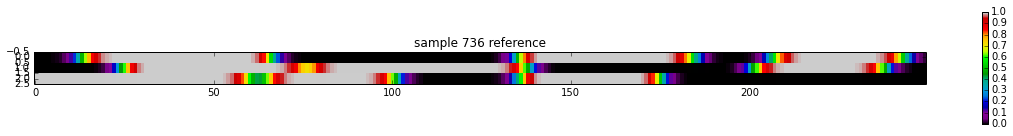

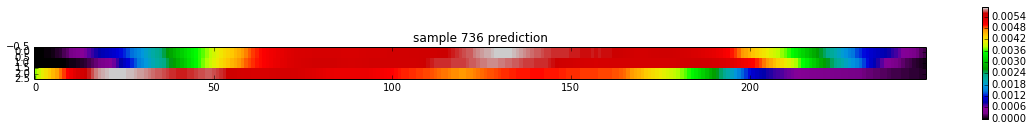

count_distr: [ 0.09531541  0.27825537  0.25440702  0.17352416  0.19849806] actual: 2


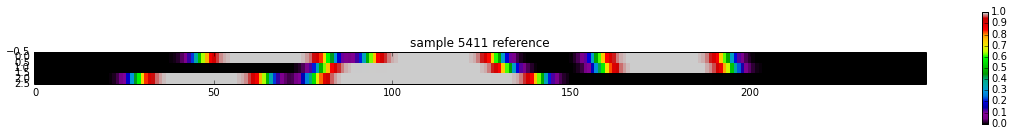

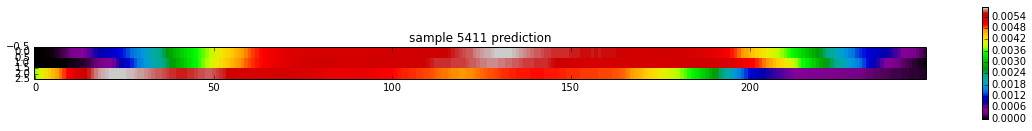

count_distr: [ 0.09531542  0.27825525  0.25440714  0.17352481  0.19849737] actual: 1


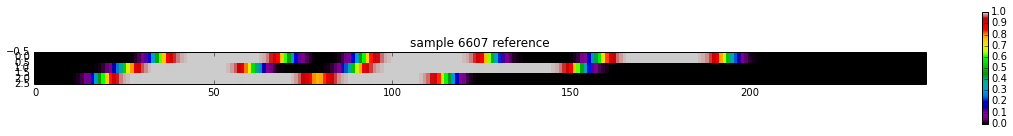

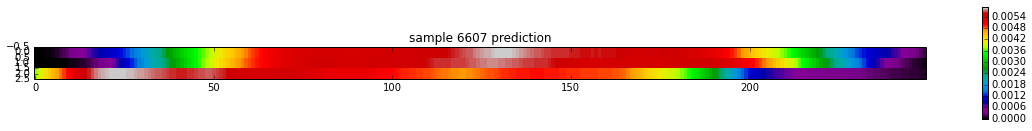

count_distr: [ 0.09531532  0.27825588  0.2544086   0.17352681  0.19849339] actual: 2


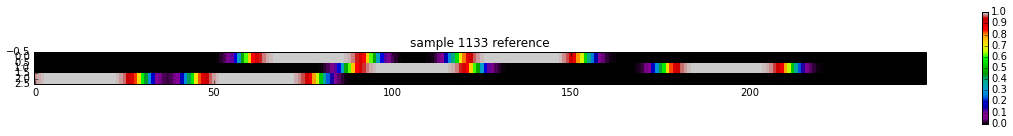

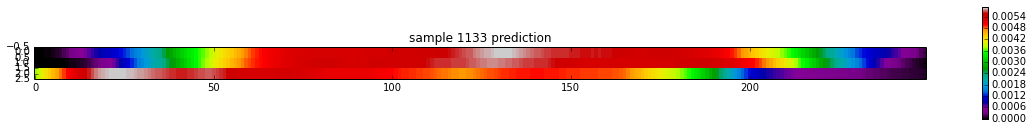

count_distr: [ 0.09531539  0.27825516  0.25440732  0.17352523  0.19849691] actual: 1


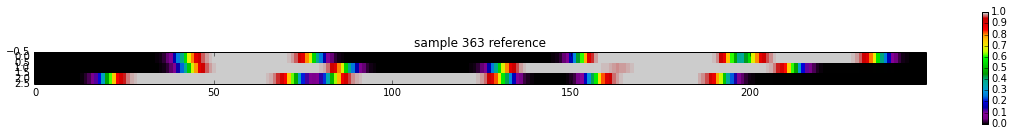

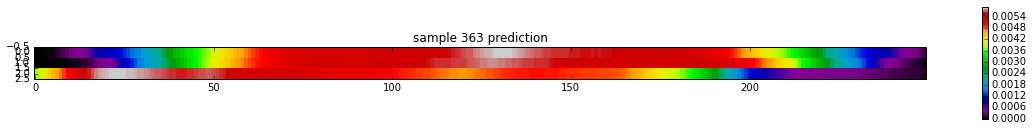

count_distr: [ 0.09531541  0.27825537  0.25440702  0.17352416  0.19849806] actual: 3


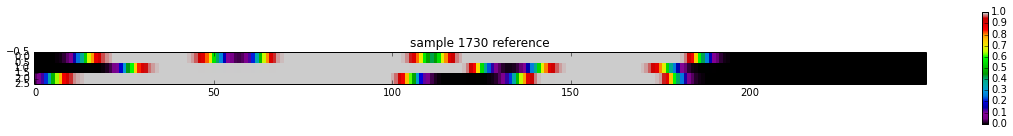

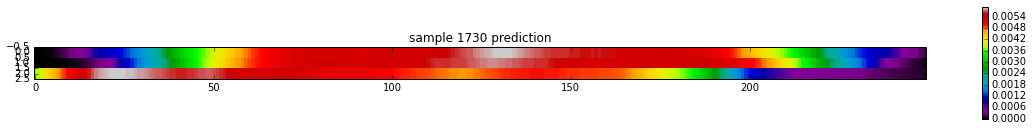

In [35]:
show_sample_predictions(Xtr,Ytr,Yctr,3)
show_sample_predictions(Xts,Yts,Ycts,3)

In [32]:
print "Final scores on the training set:"
evaluate(Xtr,Ytr,Yctr)

show_sample_predictions(Xtr,Ytr,Yctr,3)

print "Final scores on the test set:"
evaluate(Xts,Yts,Ycts)

show_sample_predictions(Xts,Yts,Ycts,3)

Final scores on the training set:


KeyboardInterrupt: 

# brief conclusion
TODO

In [ ]:
# here the notebook ends

In [ ]:
ww = _nn_weights[0].get_value().T.reshape(-1,64,32)

In [ ]:
from random import choice
i = choice(range(100))
plt.figure(figsize=[7,14])
plt.imshow(ww[i],cmap='bone')
plt.colorbar()
print i


# gradient reversal trick
used here to make network output more like the actual activation map

In [31]:
prefix = "discriminator."

_reference_input_layer = lasagne.layers.InputLayer(shape = output_shape,name='reference',
                                input_var=_decay_map)

#add reverse grad layer on top of the main nn
_disc_nn = ReverseGradientLayer(_nn,1.,
                                      name=prefix+'reversal_layer')


#mix predicted and reference activations
_disc_nn = lasagne.layers.concat([_disc_nn,_reference_input_layer],axis=1)
_disc_nn = lasagne.layers.reshape(_disc_nn,[-1]+output_shape[1:])
#now the predicted and reference activation pics are intertwined (pred,ref,pred,ref,...)




#maybe a convnet here?
_disc_nn = lasagne.layers.DenseLayer(_disc_nn,128,
                                           name=prefix+"dense0",
                                           nonlinearity=lasagne.nonlinearities.tanh)
_disc_nn = lasagne.layers.DenseLayer(_disc_nn,1,
                                           name = prefix+"output",
                                           nonlinearity=lasagne.nonlinearities.sigmoid)





In [32]:
_domain_prediction  = lasagne.layers.get_output(_disc_nn)


In [33]:
_domain_reference = T.repeat(T.constant(np.array([[1,0]])),_decay_map.shape[0],axis=0)
_domain_reference = _domain_reference.reshape([-1,1])


_domain_loss = lasagne.objectives.categorical_crossentropy(_domain_prediction,_domain_reference).mean()



In [34]:
_all_weights = lasagne.layers.get_all_params(_disc_nn, trainable = True)
_disc_weights = [param for param in _all_weights if param not in _nn_weights]

_disc_weights


[discriminator.dense0.W,
 discriminator.dense0.b,
 discriminator.output.W,
 discriminator.output.b]

In [ ]:
#try out binary crossentropy for mail NN? - after finding out how exactly it is computed
_domain_update = lasagne.updates.nesterov_momentum(_domain_loss,
                                               params = _all_weights,
                                               learning_rate = .01
                                              )



In [ ]:
# compiled optimization algorithm
domain_train_fun = theano.function([_input_image_pair,_decay_map],
                            _domain_loss,
                            updates=_domain_update,
                           #mode=theano.compile.mode.FAST_COMPILE
                           )



In [ ]:
n_epochs= 500
batch_size = 500
for i in range(n_epochs):
    err=[]
    for (batch_X,batch_y) in iterate_minibatches(Xtr,Ytr,batch_size,shuffle=True):
        err.append(domain_train_fun(batch_X,batch_y))
    
    
    print 'train loss: ',np.mean(err)
    if epochCounter%25==0:
        print '-'*25
        print 'epoch {}/{}, {} total'.format(i,n_epochs,epochCounter)
        print
        
        print "layer RMS:"
        for param in _nn_weights:
            RMS_weights = (param.get_value()**2).mean()**.5
            print '\t',param,':',RMS_weights
        print
        
        
        
        show_sample_predictions(Xtr,Ytr,count=3)
    
    epochCounter+=1

